# 03_RL_DQN

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ===============================================
# Environment 클래스
# ===============================================
class StockEnvironment:
    def __init__(self, 
                 prices='C:/Users/minmi/OneDrive/바탕 화면/baf/25-1 금융1팀/stock_data/merge_Close.csv', 
                 capital=5e7,
                 mode='train'):
        """
        mode='train':   2024-01-01 ~ 2024-12-31
        mode='test':    2025-01-01 ~ 2025-02-28
        """
        self.prices = prices
        self.capital = capital
        self.mode = mode

        # 데이터셋 불러오기 + 구간 분할
        self.train_data, self.test_data = self.load_and_split_data()

        # 모드에 따른 데이터셋 결정
        if self.mode == 'train':
            self.data = self.train_data
        else:
            self.data = self.test_data

        # 데이터 길이
        self.data_len = len(self.data)

    def load_and_split_data(self):
        data = pd.read_csv(self.prices, index_col=0)
        data.index = pd.to_datetime(data.index)

        # 날짜 기준으로 학습/테스트 구간 분할
        train_data = data.loc['2024-01-01':'2024-12-31']
        test_data  = data.loc['2025-01-01':'2025-02-28']

        train_data.reset_index(drop=True, inplace=True)
        test_data.reset_index(drop=True, inplace=True)

        return train_data, test_data

    def get_state(self, t, lookback=90):
        assert lookback <= t, "lookback은 t 이하여야 합니다."
        window = self.data.iloc[t - lookback : t]
        window = window.pct_change().dropna()  # 일간 수익률
        return window.cov()  # 공분산 행렬

    def get_reward(self, weights, action_t, reward_t):
        # 안전장치
        if action_t < 0:
            action_t = 0
        if reward_t > self.data_len:
            reward_t = self.data_len

        data_period = self.data.iloc[action_t : reward_t]
        returns = data_period.pct_change().dropna()

        # 평균 수익률 & 공분산
        rets = returns.mean()
        covs = returns.cov()

        P_ret = np.sum(rets * weights)
        P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
        P_sharpe = P_ret / P_vol if P_vol != 0 else 0

        # 날짜별 포트폴리오 수익률
        portfolio_returns = np.dot(returns, weights)
        sharpe_vec = np.array([P_sharpe] * len(weights))

        return portfolio_returns, sharpe_vec


In [4]:
# ===============================================
# Part 3) Agent 클래스
# ===============================================
class Agent:
    def __init__(self, portfolio_size, allow_short=False):
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size)  # 공분산행렬 shape
        self.action_size = 3  # sit, buy, sell
        self.memory = []

        # Q-learning 파라미터
        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.model = self._build_model()
        self.is_eval = False  # 테스트 시 True로 전환

    def _build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        outputs = [
            Dense(self.action_size, activation='linear')(x)
            for _ in range(self.portfolio_size)
        ]
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred):
        """
        pred: list[ np.array([Q_sit, Q_buy, Q_sell]), ... ] (길이=portfolio_size)
        """
        import numpy as np
        weights = np.zeros(len(pred))
        pred = [np.squeeze(p) for p in pred]  # shape (3,)

        raw_weights = [np.argmax(p) for p in pred]  # 0=sit, 1=buy, 2=sell
        for i, r in enumerate(raw_weights):
            if r == 1:  # buy
                weights[i] = abs(pred[i][r])
            elif r == 2:  # sell
                weights[i] = -abs(pred[i][r])
            else:         # sit
                weights[i] = 0

        # short 불가능이면 음수->0
        if not self.allow_short:
            weights += abs(np.min(weights))

        # 정규화(합=1)
        if np.sum(weights) != 0:
            weights /= np.sum(weights)
        else:
            weights = np.ones(len(weights)) / len(weights)
        return weights

    def act(self, state):
        import random, numpy as np

        # 탐색 or 정책
        if (not self.is_eval) and (random.random() <= self.epsilon):
            w = np.random.normal(0, 1, size=(self.portfolio_size,))
            if not self.allow_short:
                w += abs(np.min(w))
            w /= np.sum(w)
            return w

        pred = self.model.predict(np.expand_dims(state.values, 0), verbose=0)
        return self.nn_pred_to_weights(pred)

    def expReplay(self, batch_size):
        import numpy as np

        for (s, s_, a, r, done) in self.memory:
            # 행동 a를 0/양수/음수로 변환
            a_ = a * np.sum(a)
            if not self.allow_short:
                a_ = a_ - np.min(a_)

            Q_target = np.zeros((self.portfolio_size, self.action_size))
            for i in range(self.portfolio_size):
                idx = 0 if a_[i] == 0 else (1 if a_[i] > 0 else 2)
                Q_target[i][idx] = r[i] + self.gamma * (
                    0 if done else np.max(
                        self.model.predict(np.expand_dims(s_.values, 0), verbose=0)[i]
                    )
                )

            # 학습
            Q_target = [q.reshape(1, -1) for q in Q_target]
            self.model.fit(np.expand_dims(s.values, 0), Q_target, epochs=1, verbose=0)

        # 탐색률 조정
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.memory = []


Episode 1/40 - Epsilon: 1.000


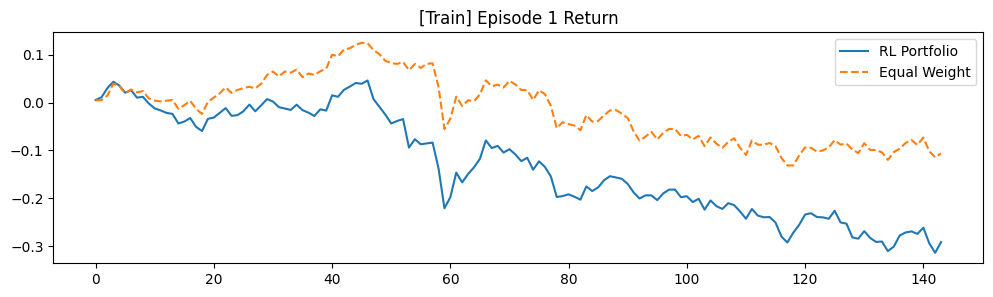

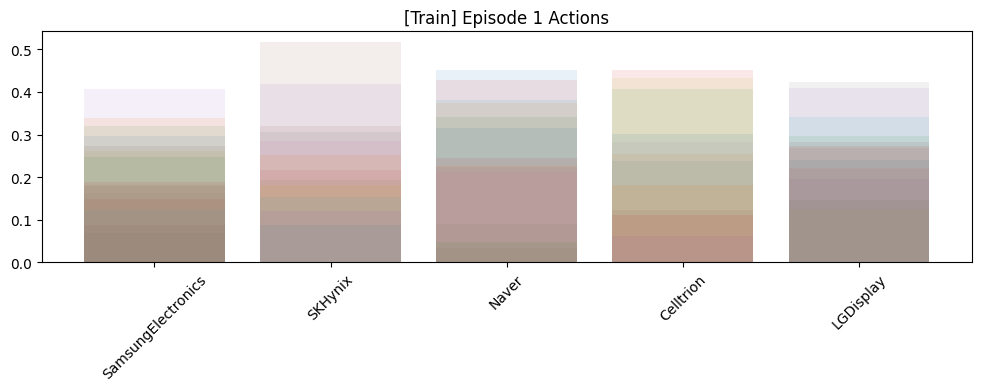

Episode 2/40 - Epsilon: 1.000


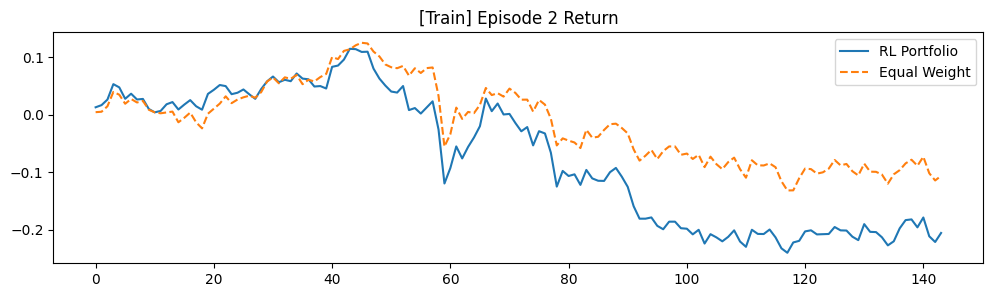

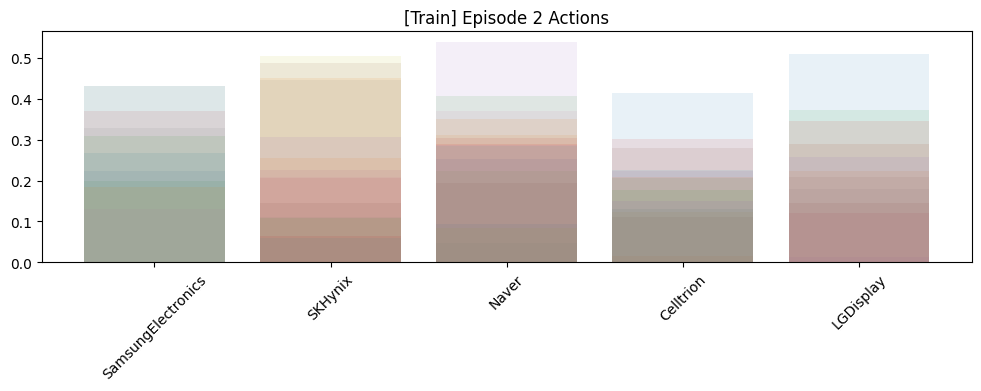

Episode 3/40 - Epsilon: 0.990


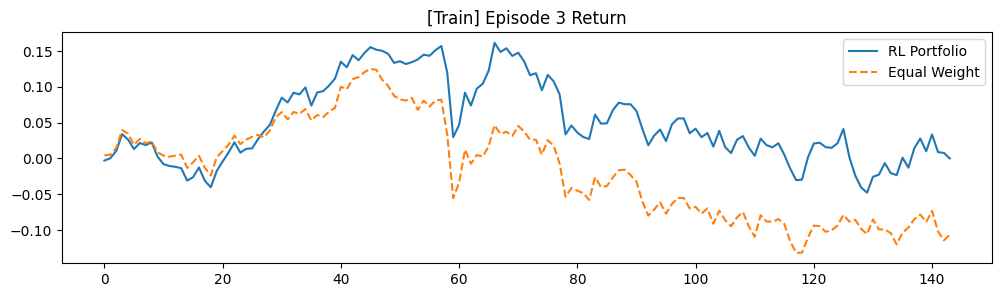

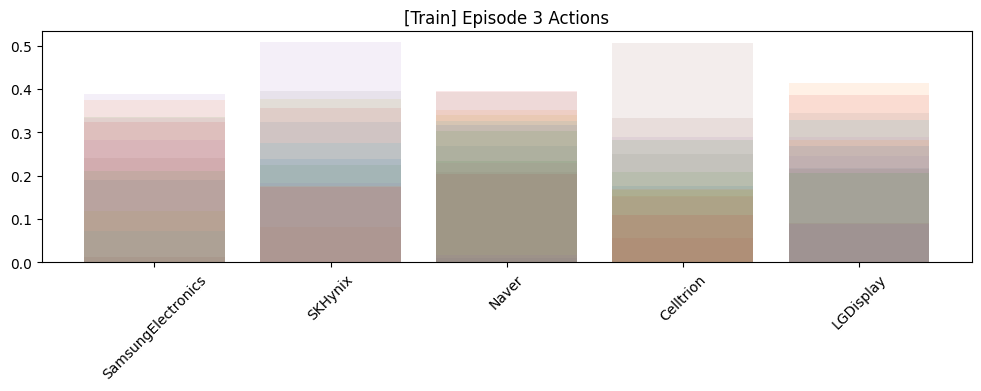

Episode 4/40 - Epsilon: 0.990


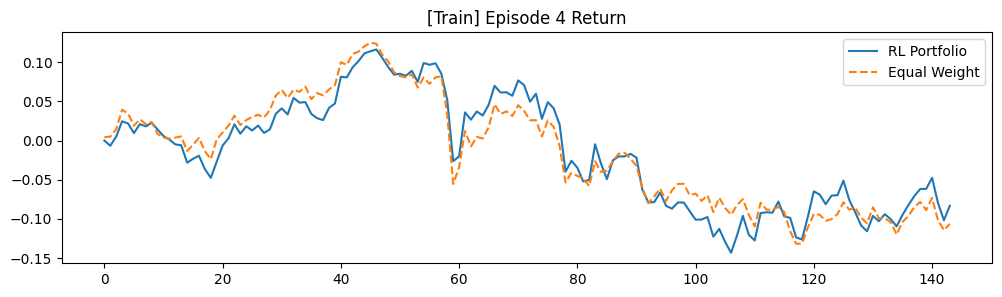

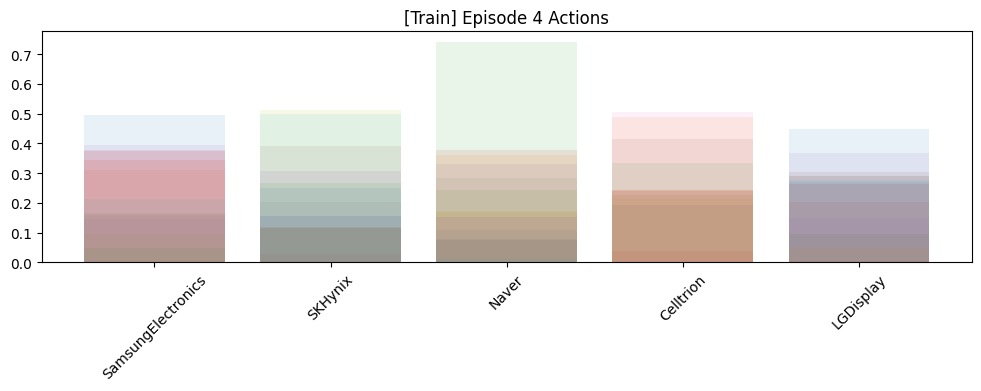

Episode 5/40 - Epsilon: 0.980


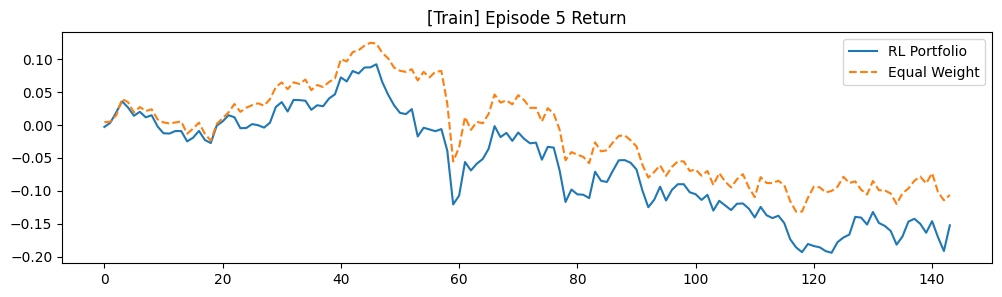

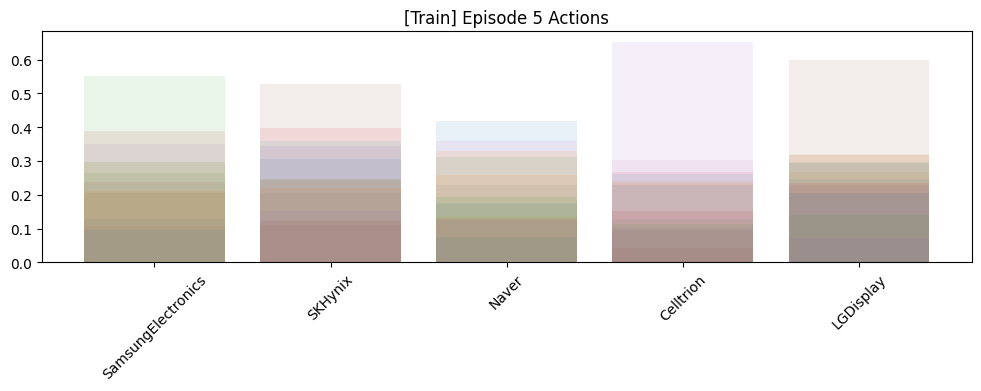

Episode 6/40 - Epsilon: 0.980


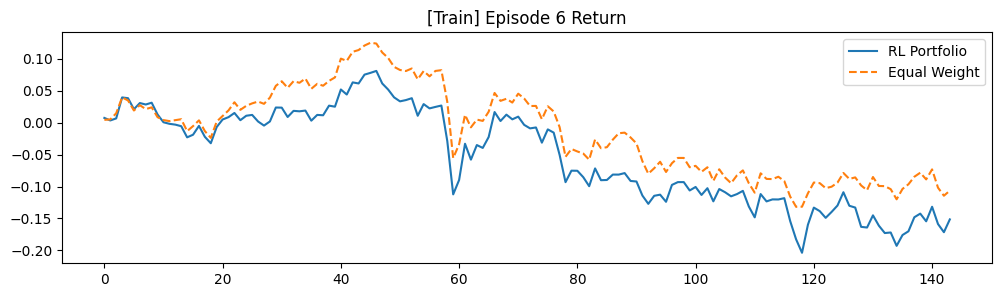

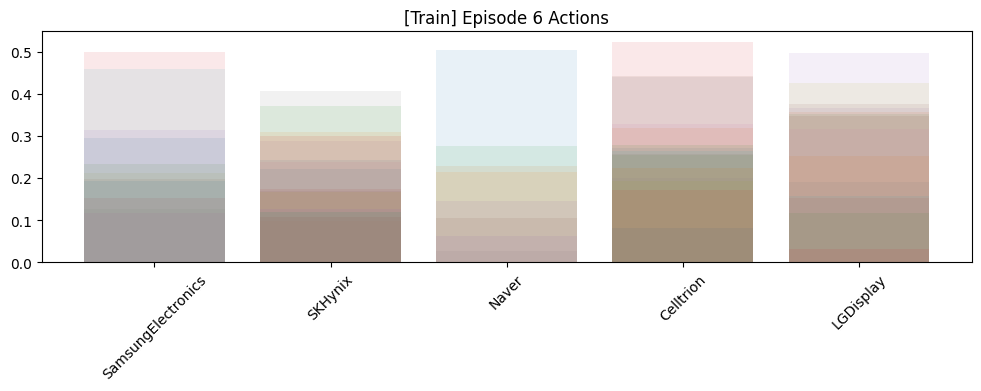

Episode 7/40 - Epsilon: 0.970


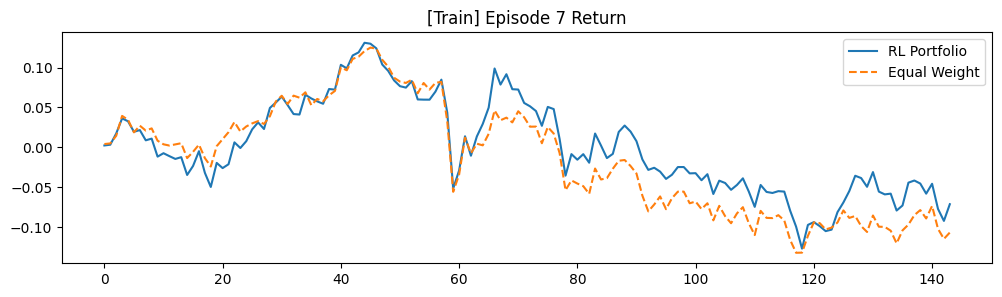

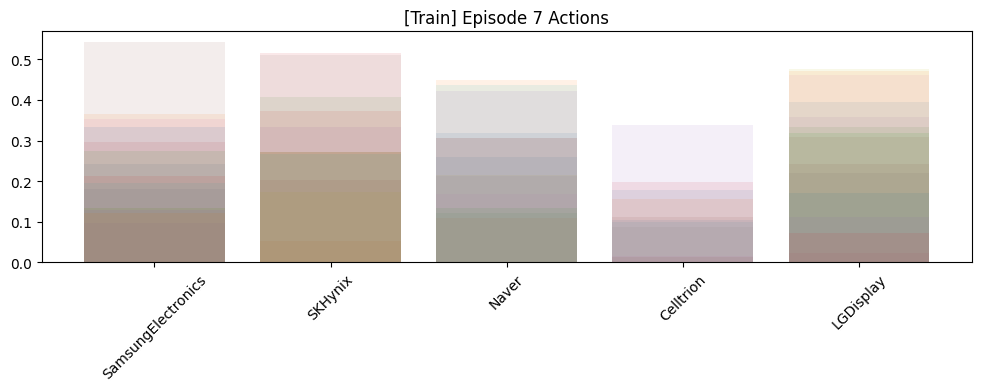

Episode 8/40 - Epsilon: 0.970


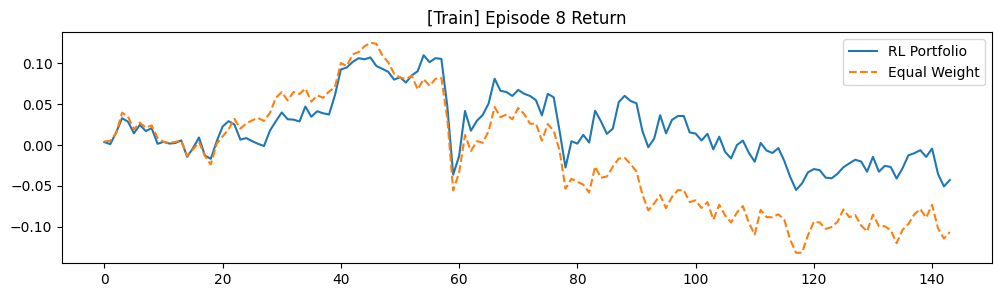

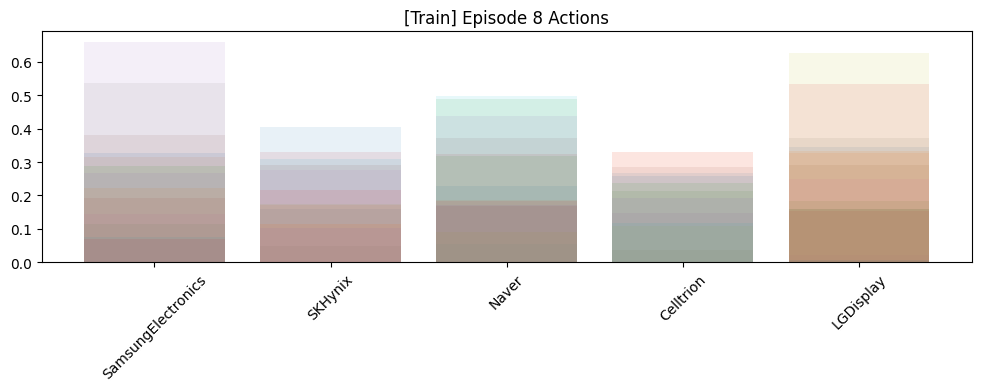

Episode 9/40 - Epsilon: 0.961


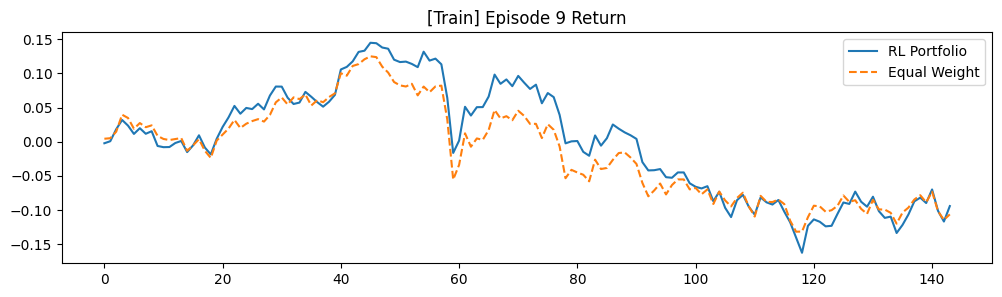

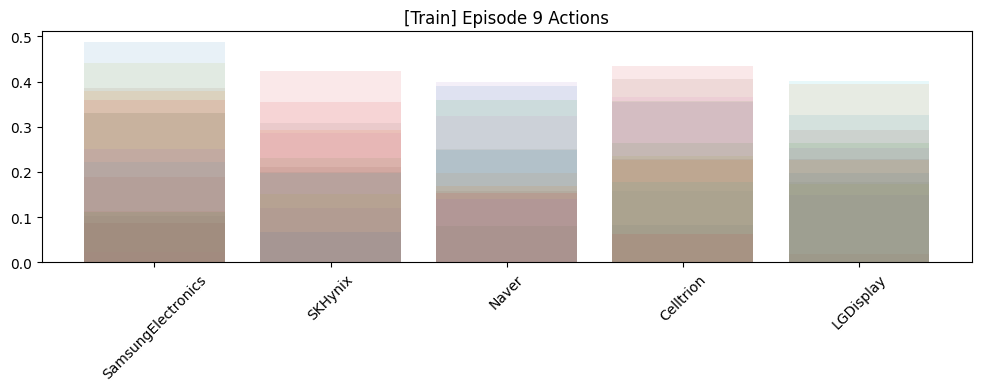

Episode 10/40 - Epsilon: 0.961


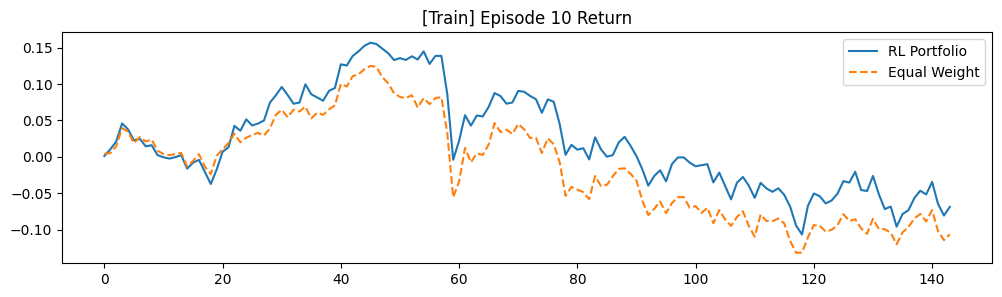

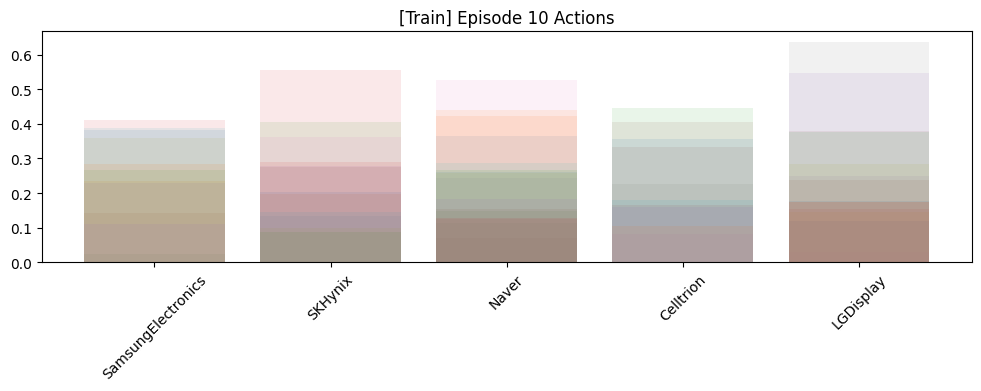

Episode 11/40 - Epsilon: 0.951


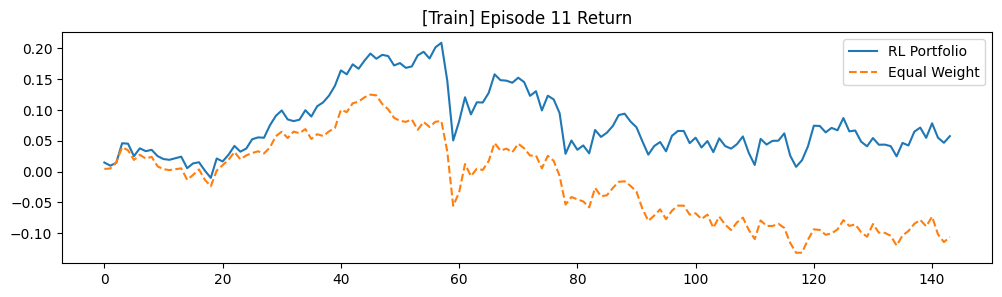

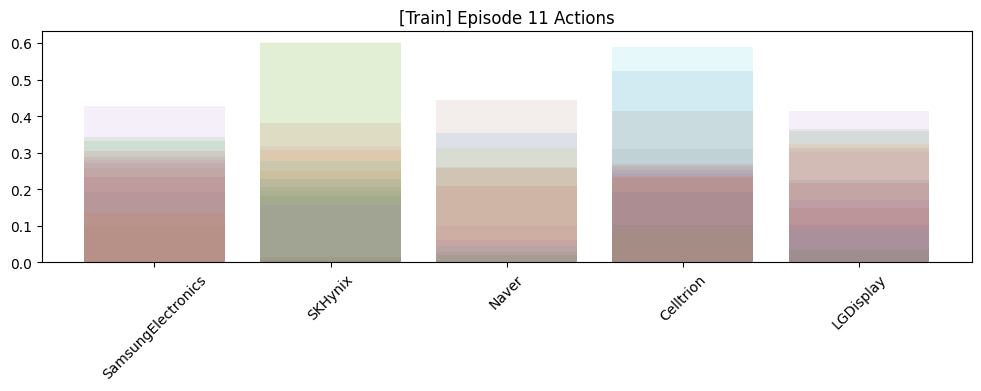

Episode 12/40 - Epsilon: 0.951


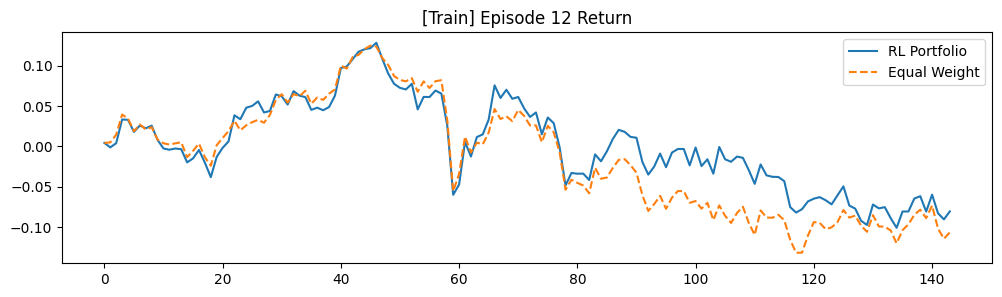

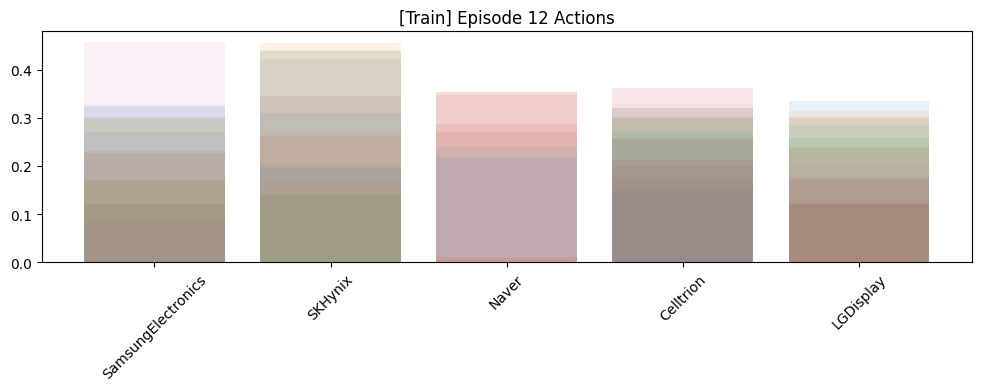

Episode 13/40 - Epsilon: 0.941


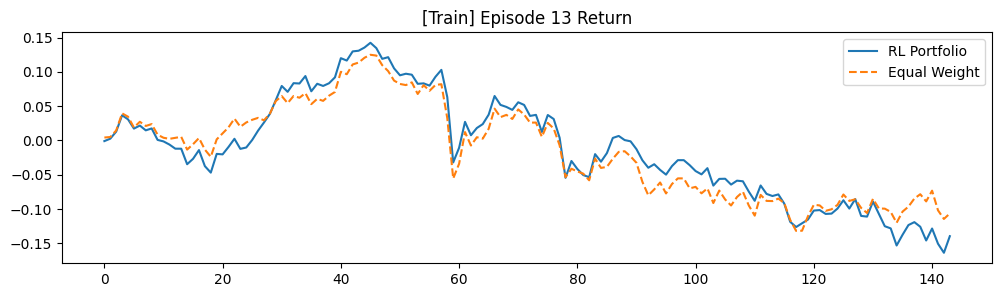

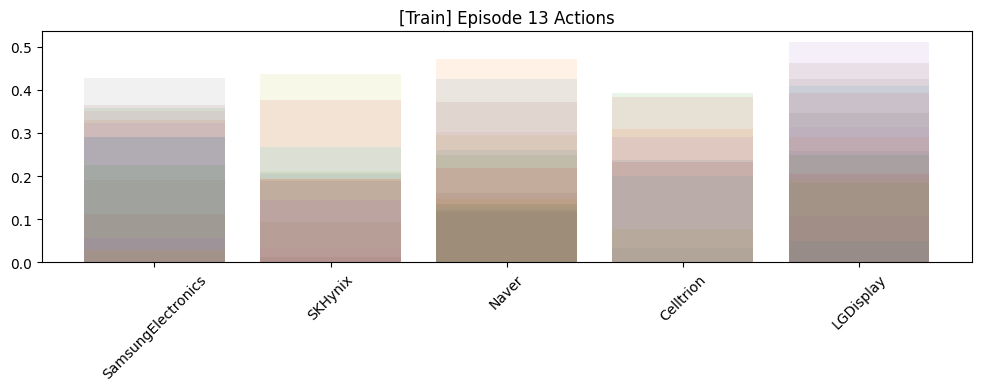

Episode 14/40 - Epsilon: 0.941


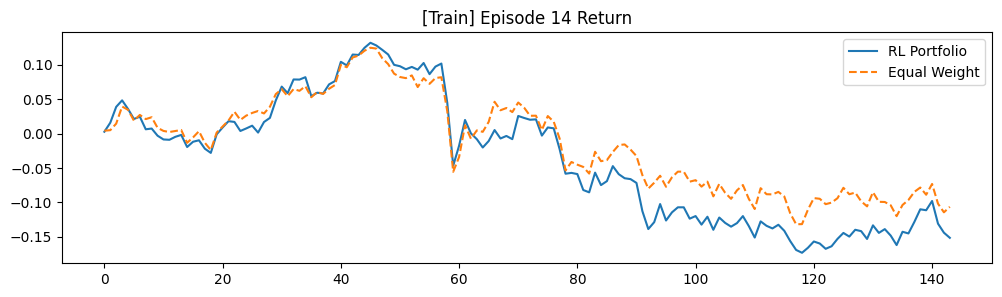

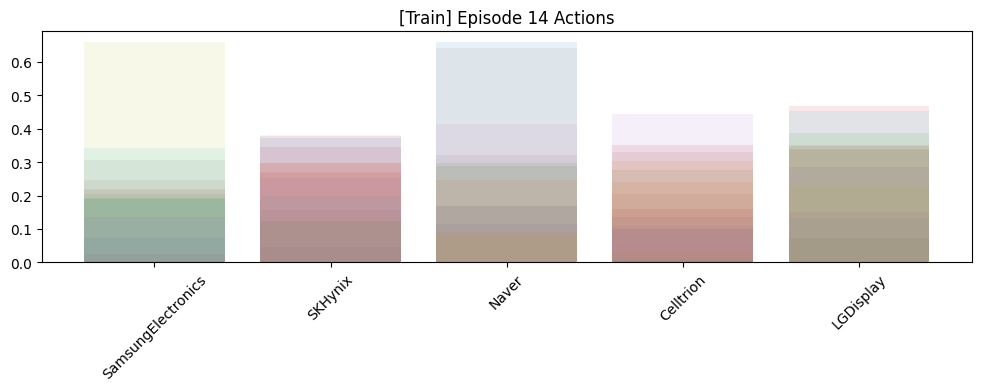

Episode 15/40 - Epsilon: 0.932


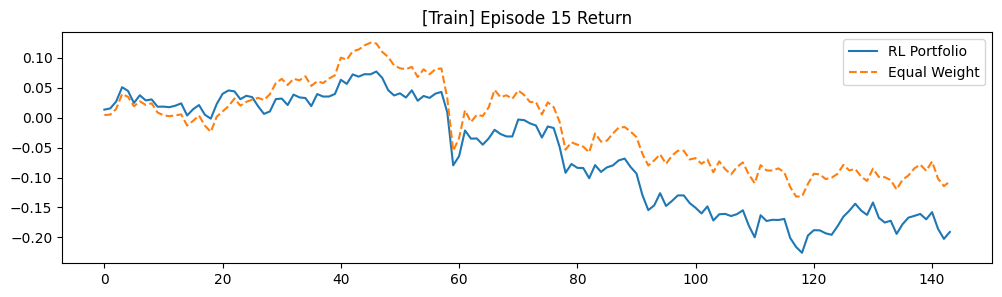

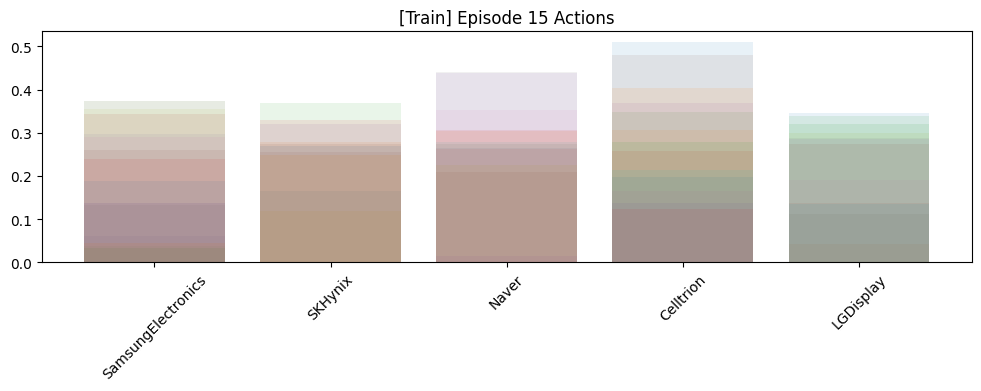

Episode 16/40 - Epsilon: 0.932


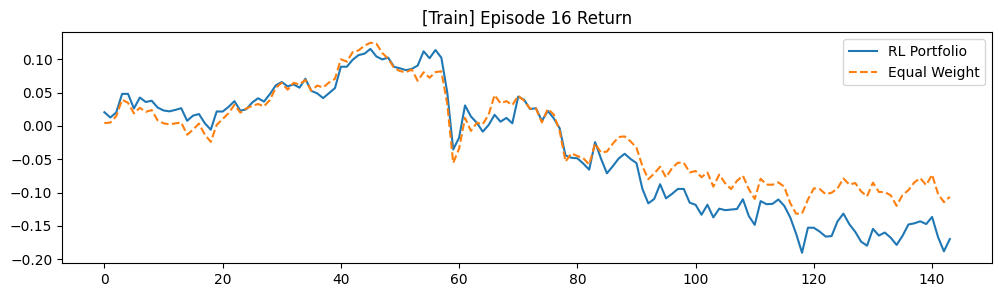

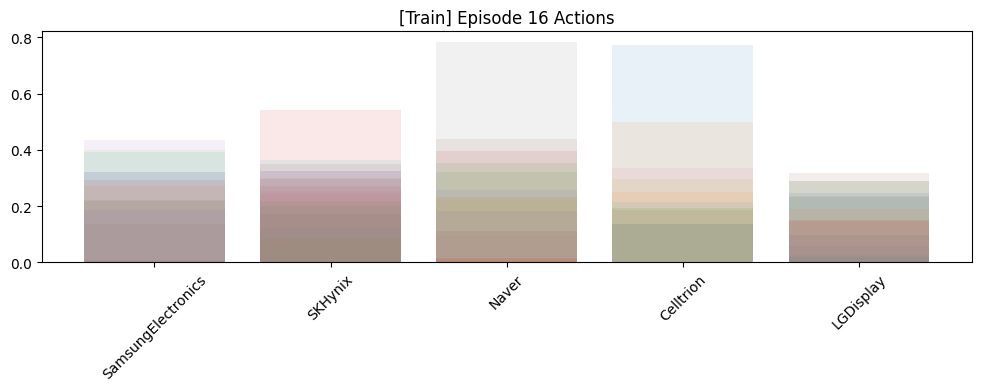

Episode 17/40 - Epsilon: 0.923


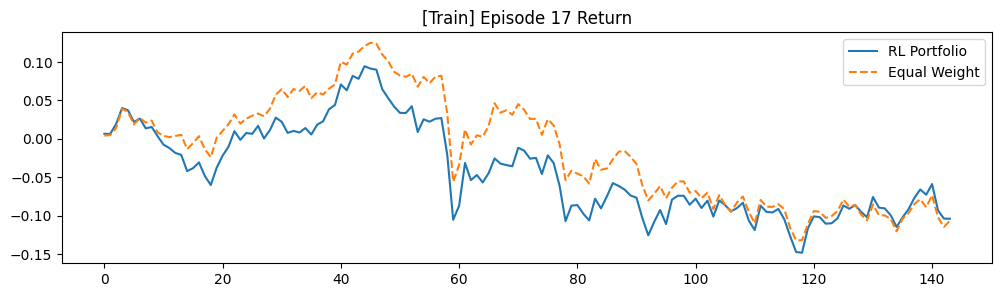

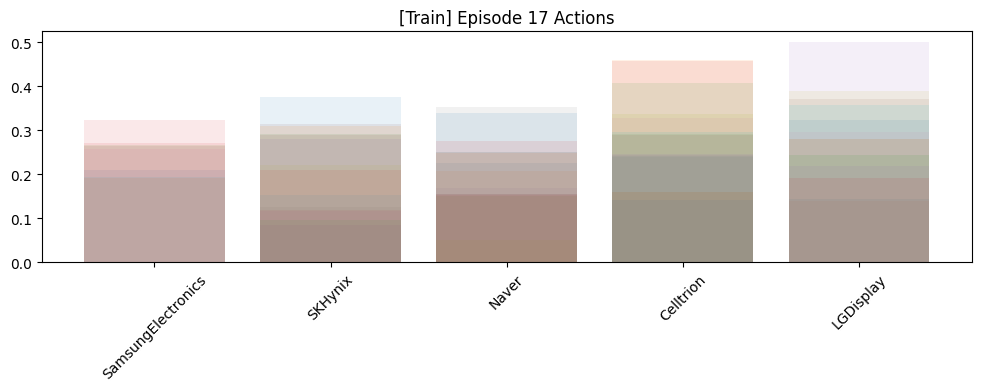

Episode 18/40 - Epsilon: 0.923


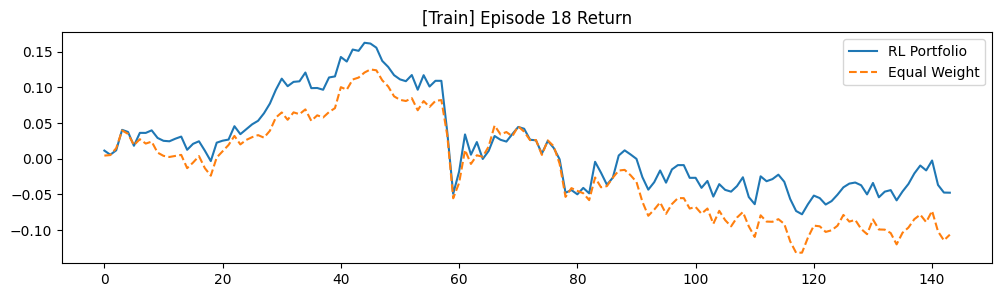

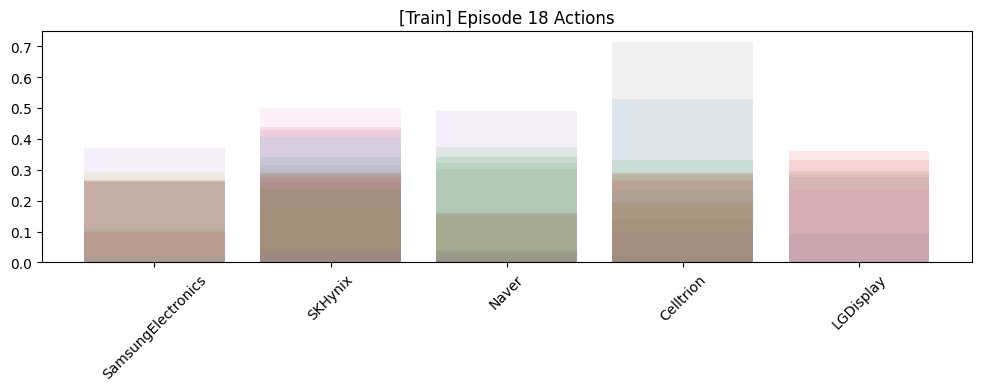

Episode 19/40 - Epsilon: 0.914


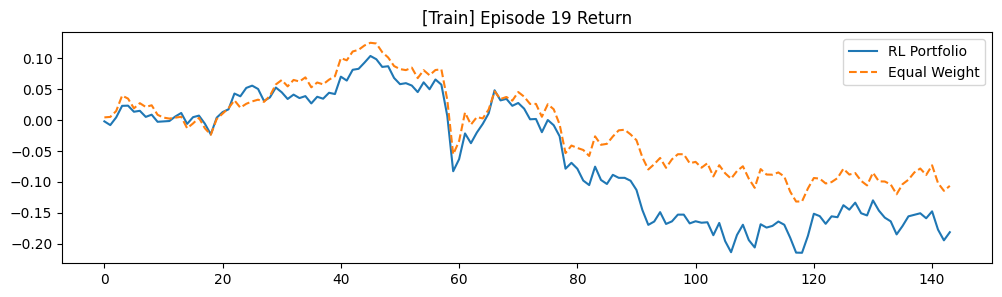

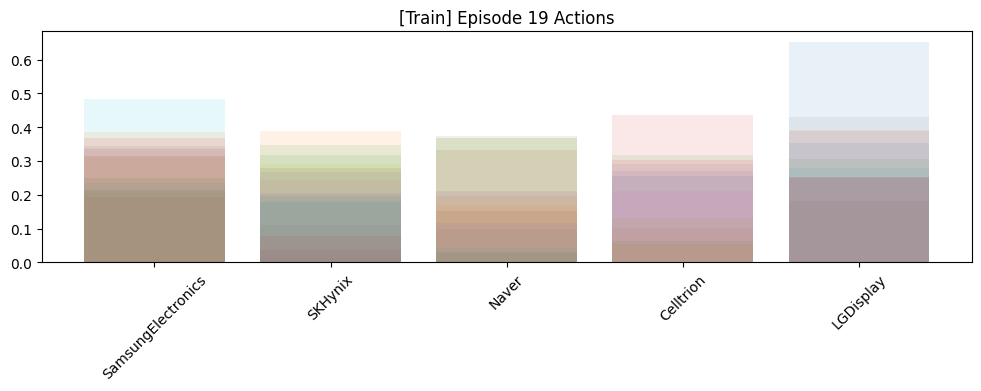

Episode 20/40 - Epsilon: 0.914


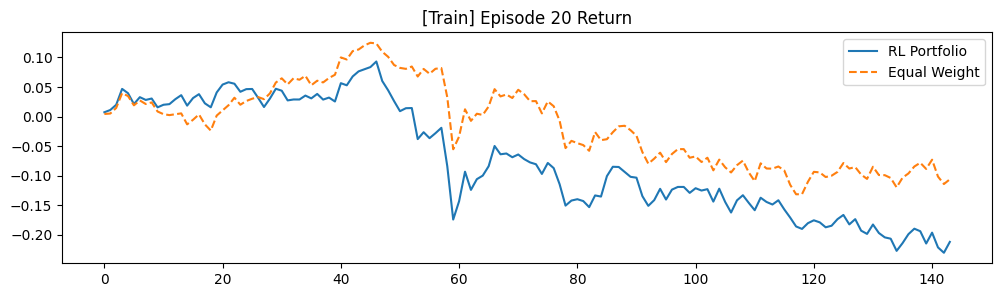

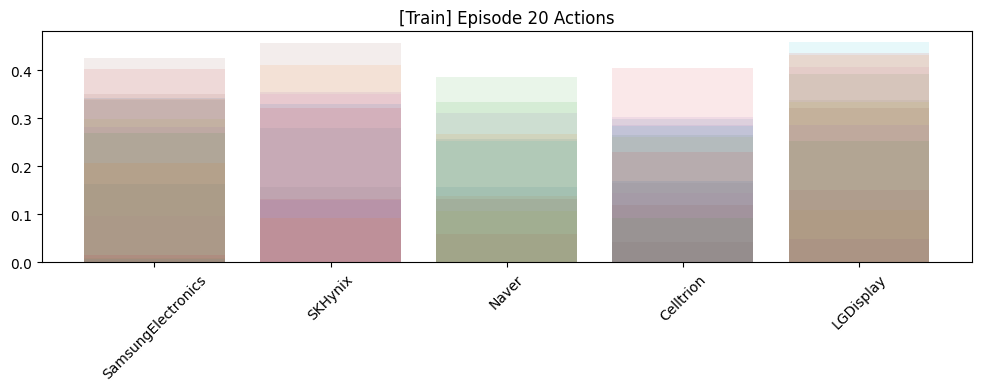

Episode 21/40 - Epsilon: 0.904


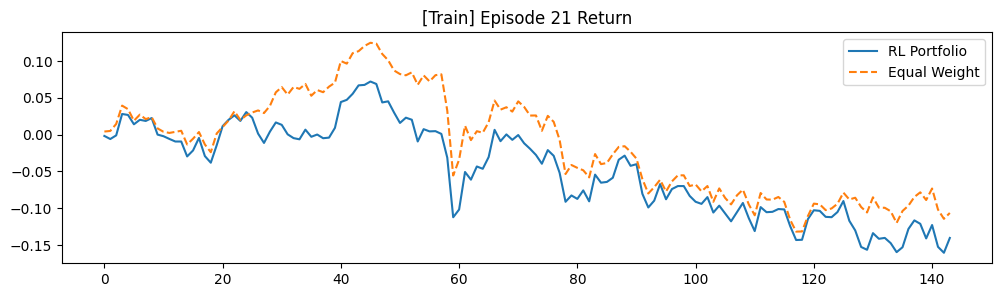

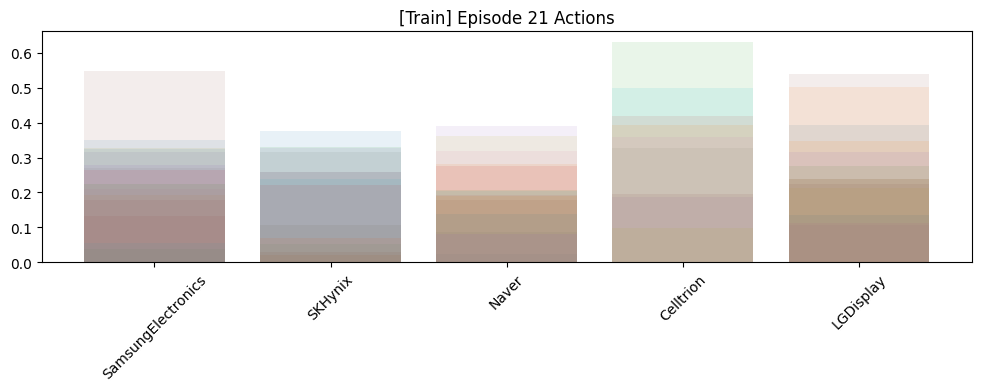

Episode 22/40 - Epsilon: 0.904


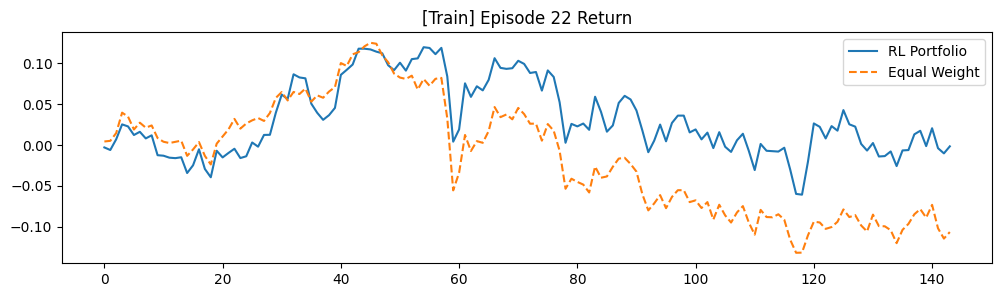

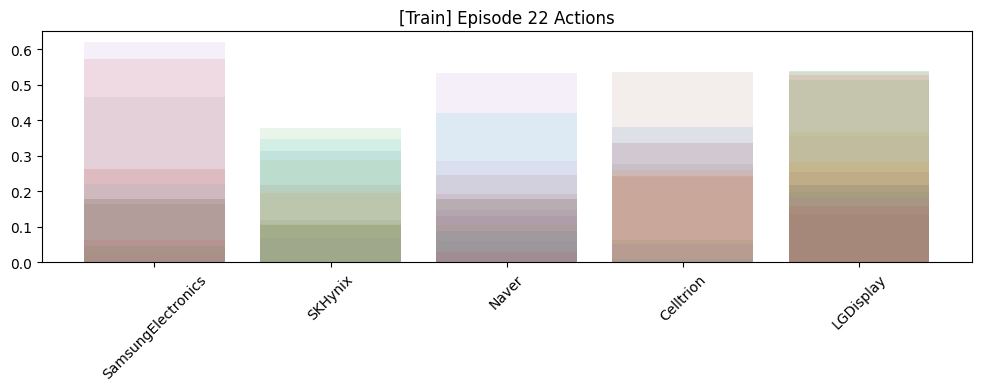

Episode 23/40 - Epsilon: 0.895


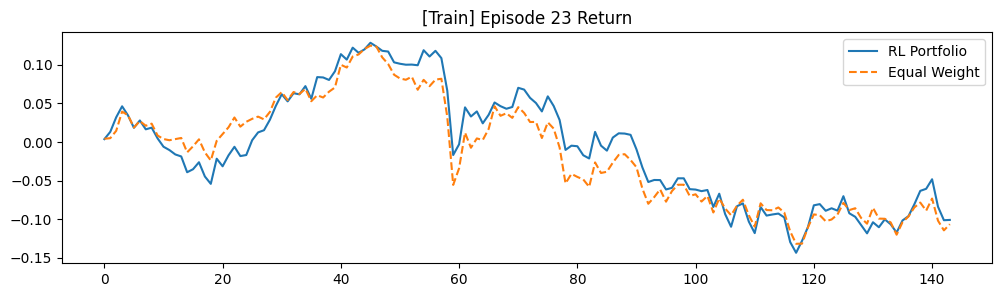

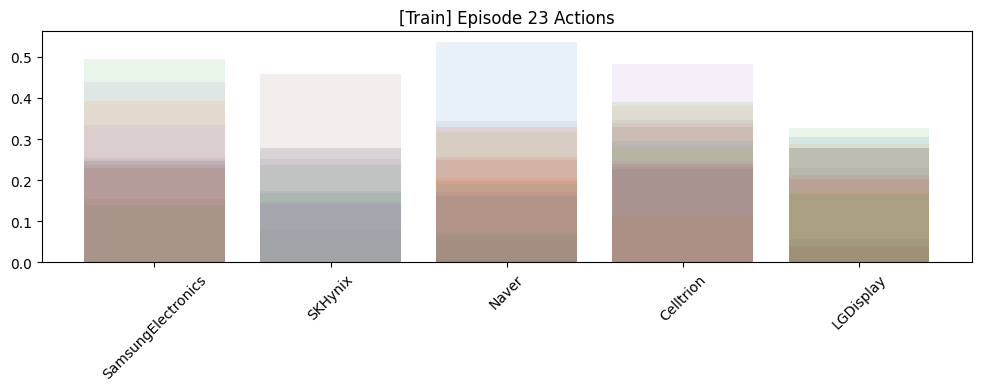

Episode 24/40 - Epsilon: 0.895


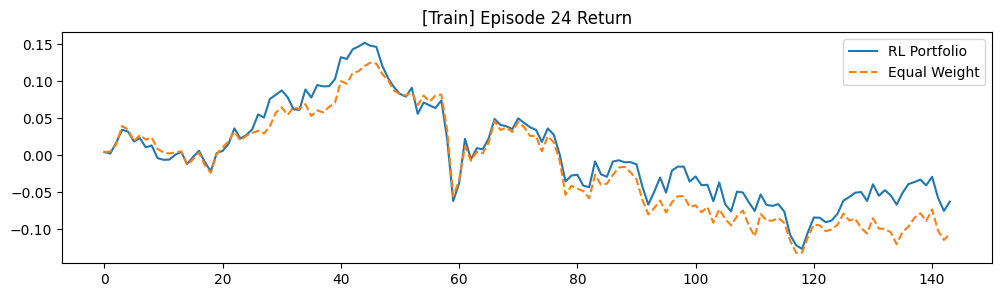

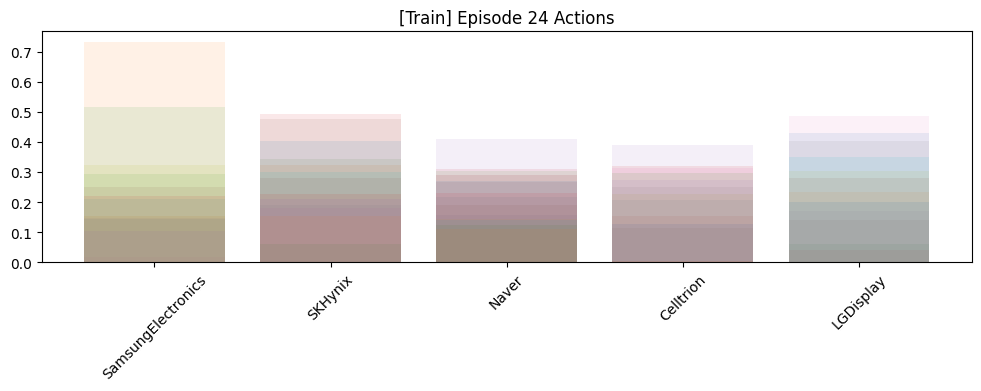

Episode 25/40 - Epsilon: 0.886


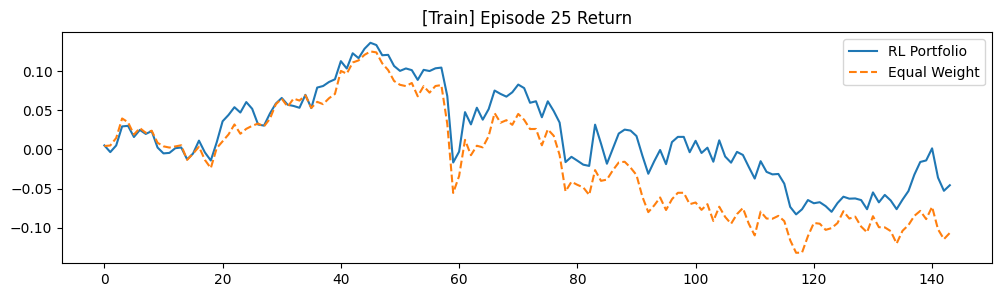

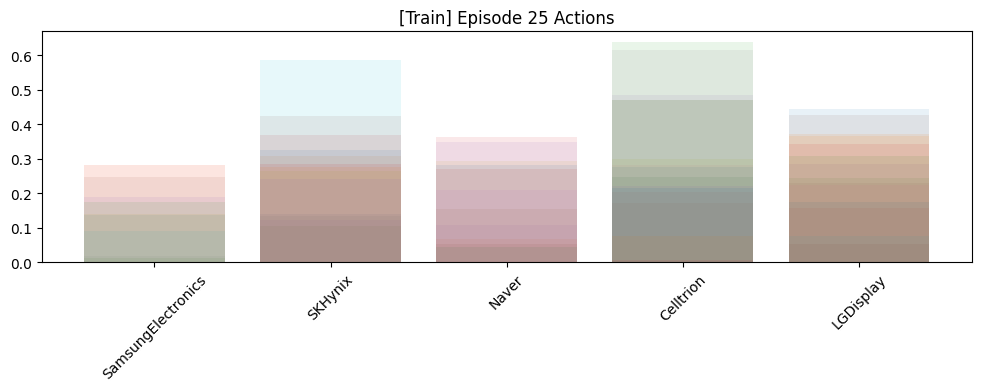

Episode 26/40 - Epsilon: 0.886


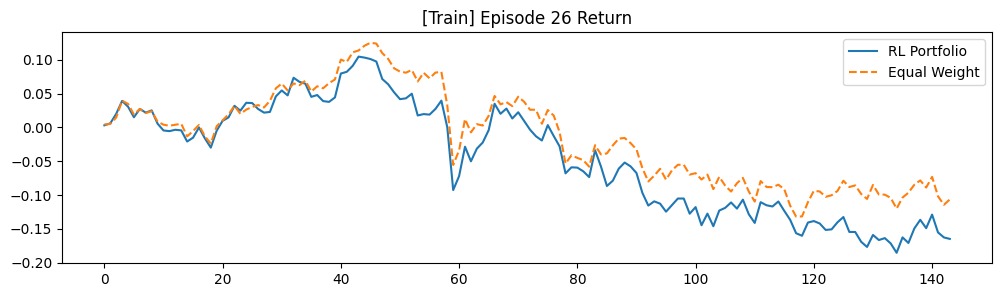

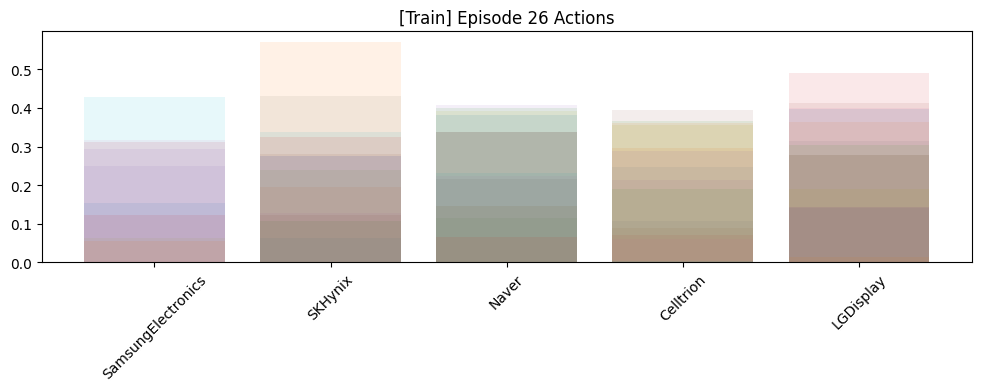

Episode 27/40 - Epsilon: 0.878


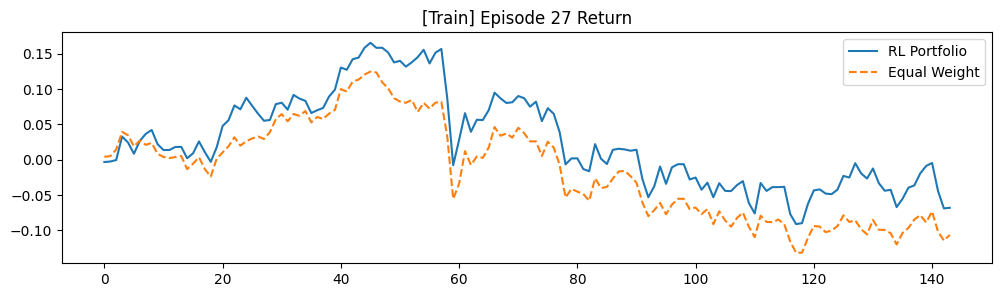

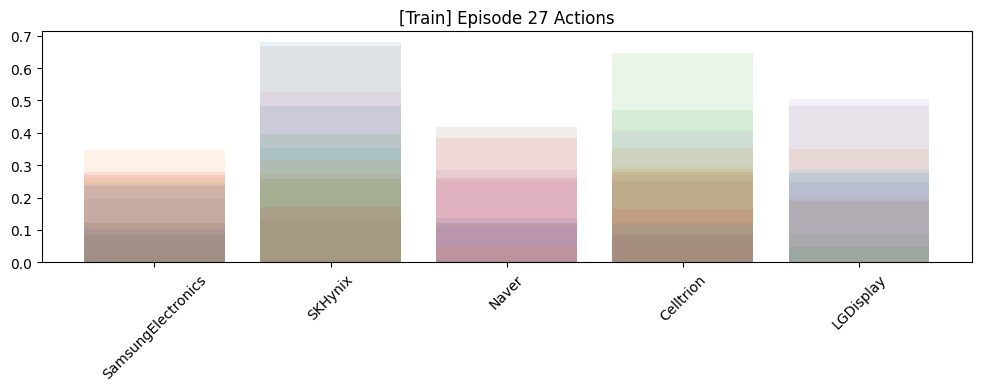

Episode 28/40 - Epsilon: 0.878


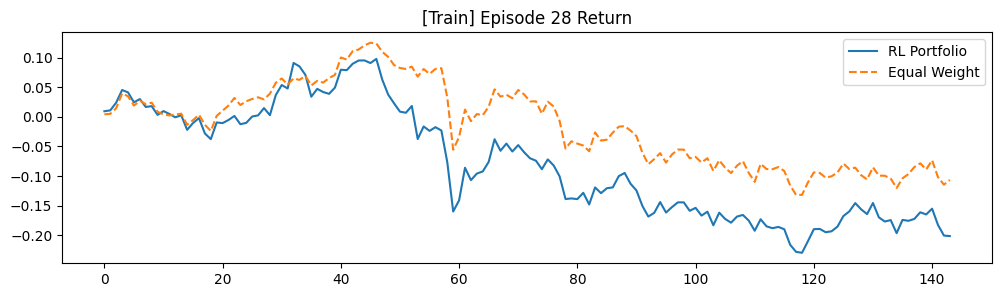

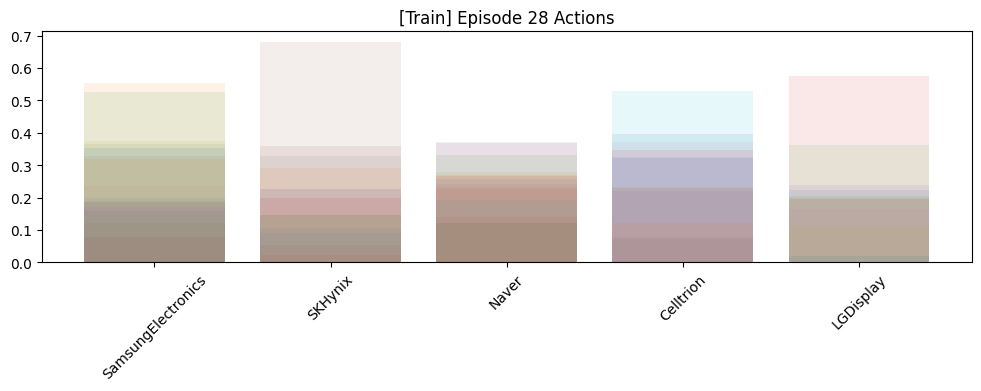

Episode 29/40 - Epsilon: 0.869


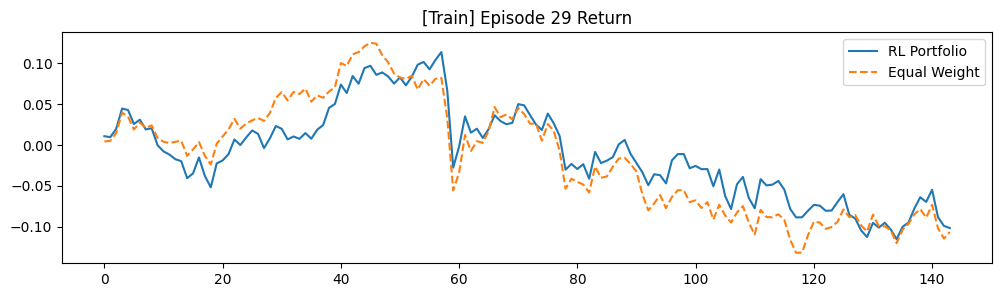

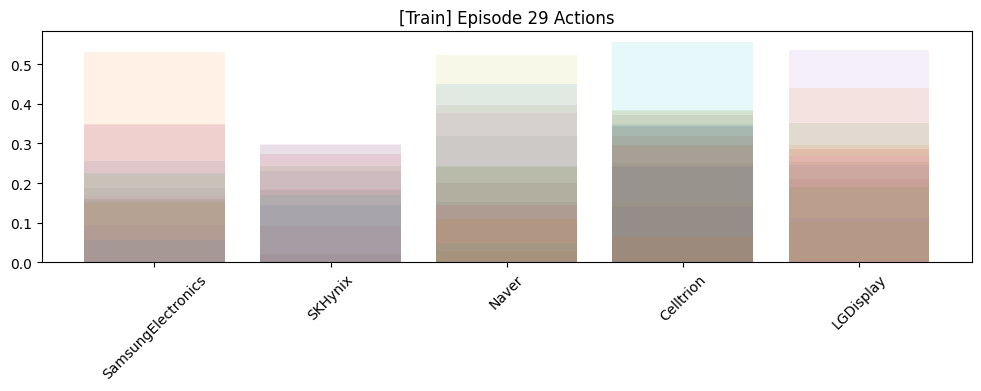

Episode 30/40 - Epsilon: 0.869


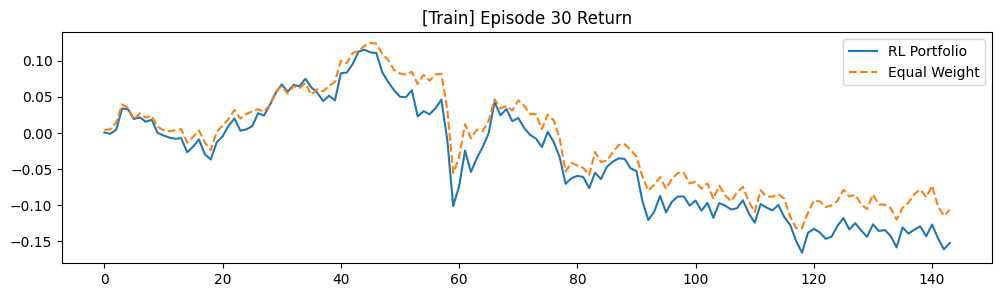

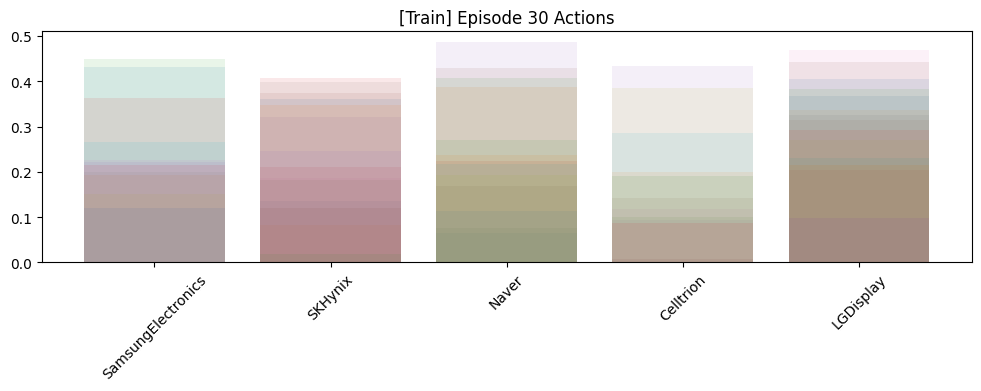

Episode 31/40 - Epsilon: 0.860


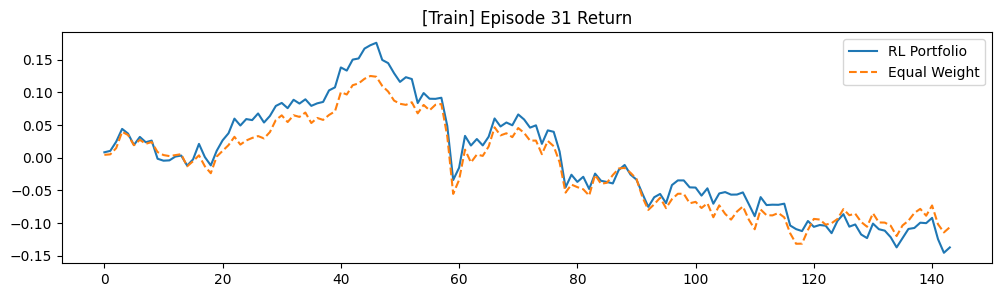

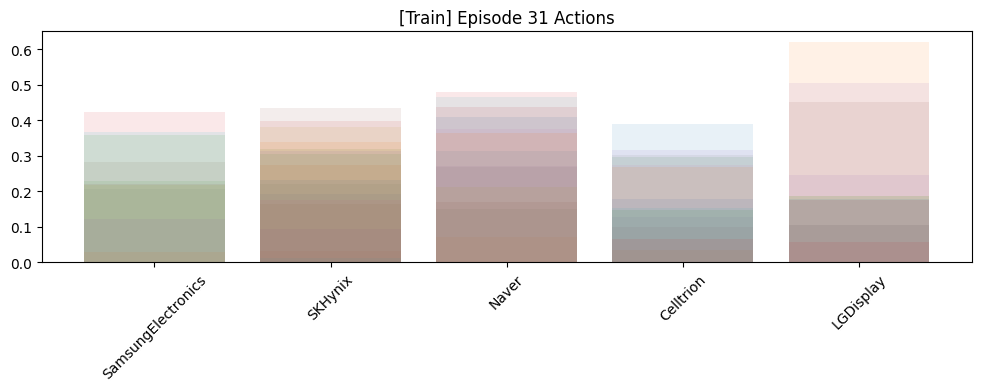

Episode 32/40 - Epsilon: 0.860


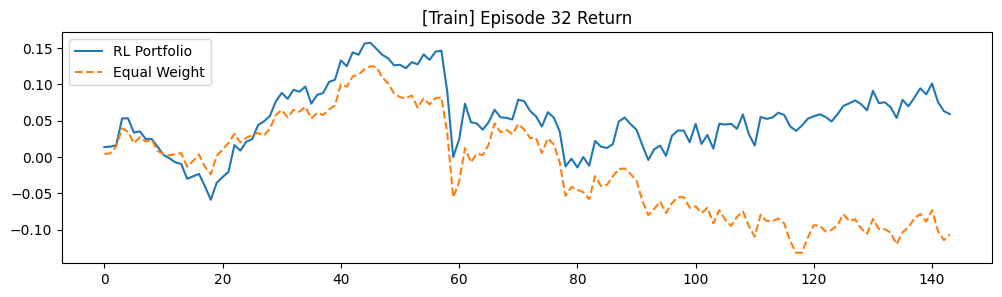

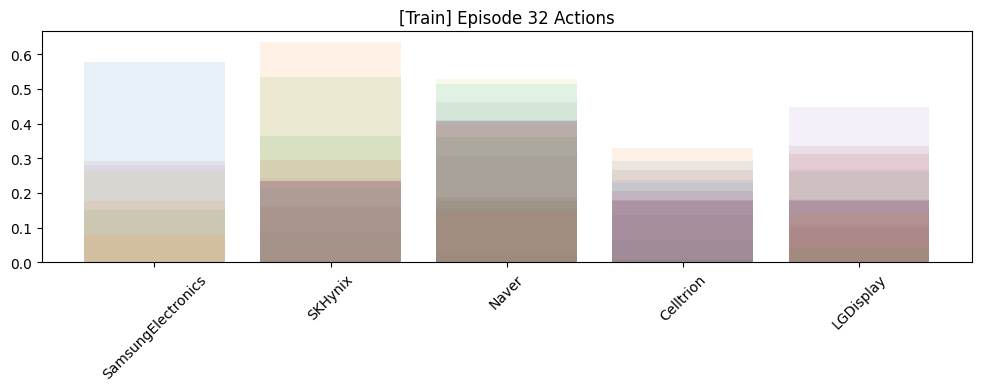

Episode 33/40 - Epsilon: 0.851


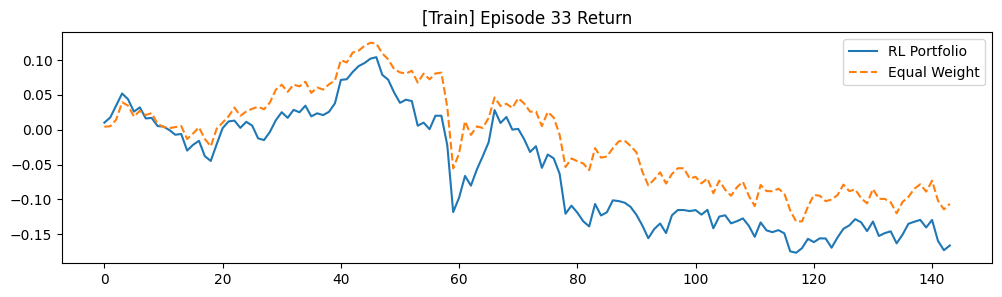

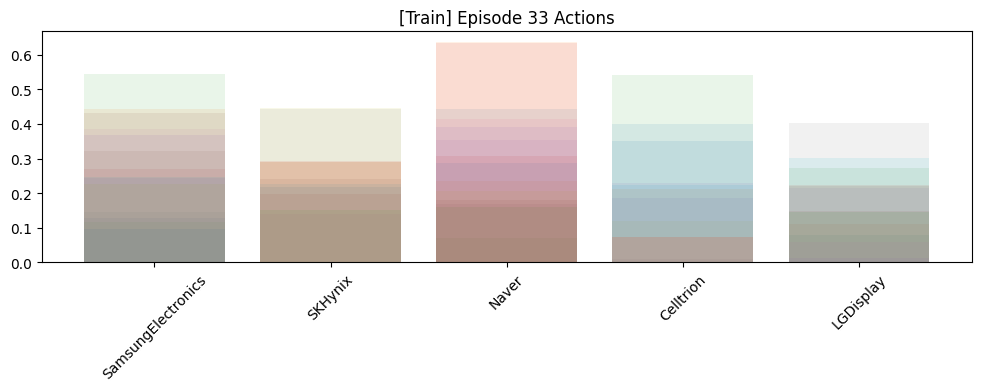

Episode 34/40 - Epsilon: 0.851


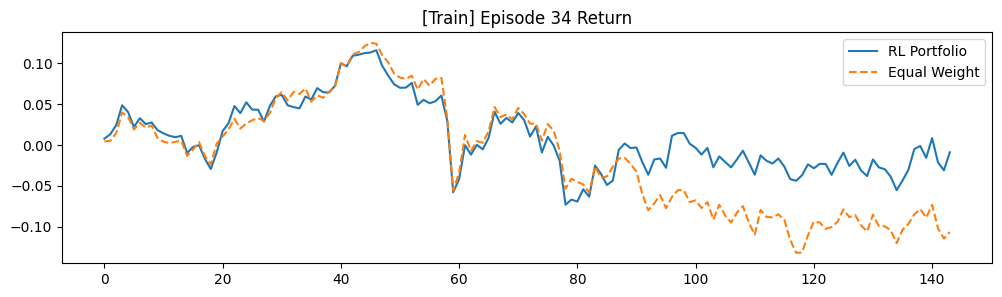

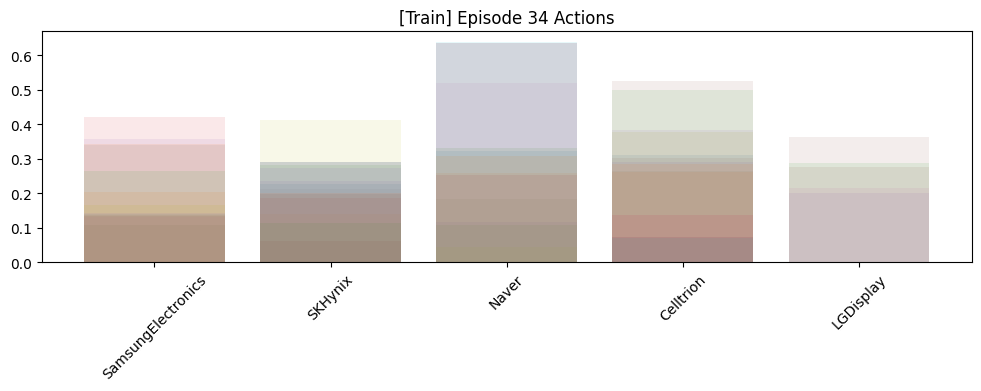

Episode 35/40 - Epsilon: 0.843


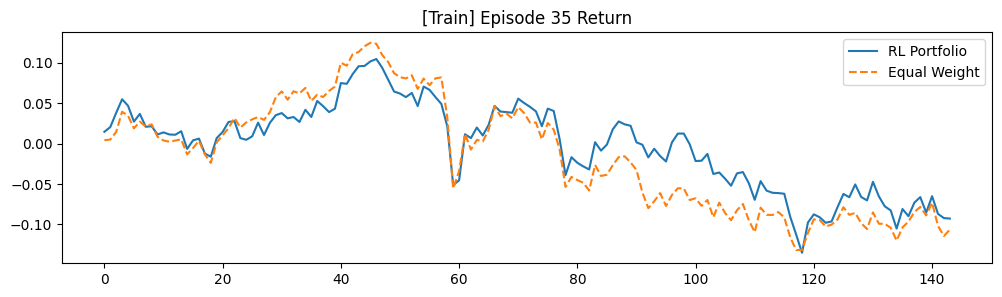

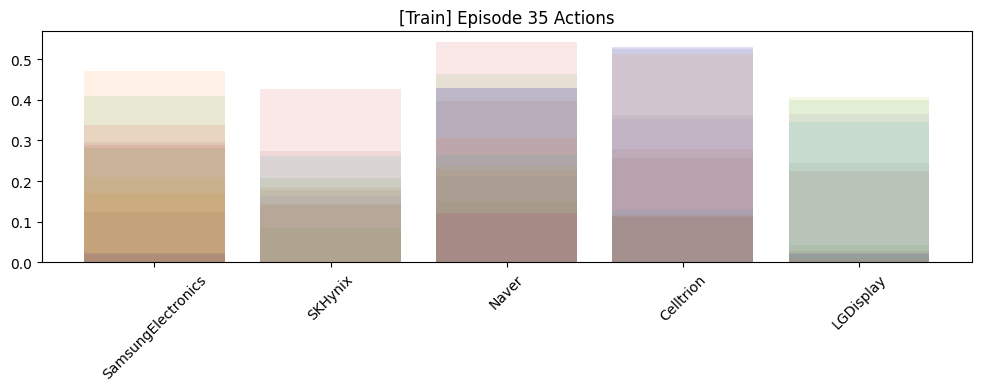

Episode 36/40 - Epsilon: 0.843


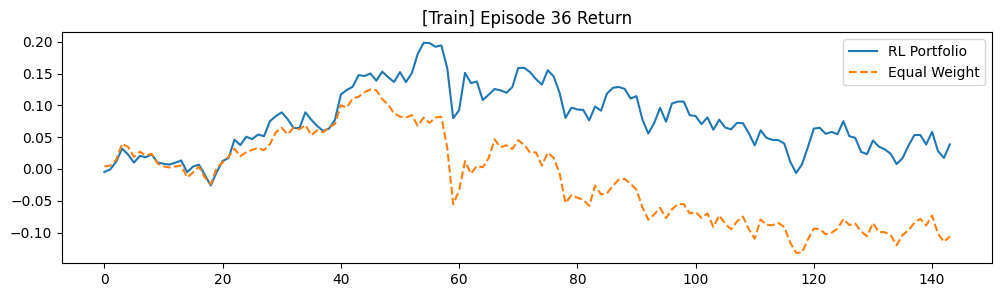

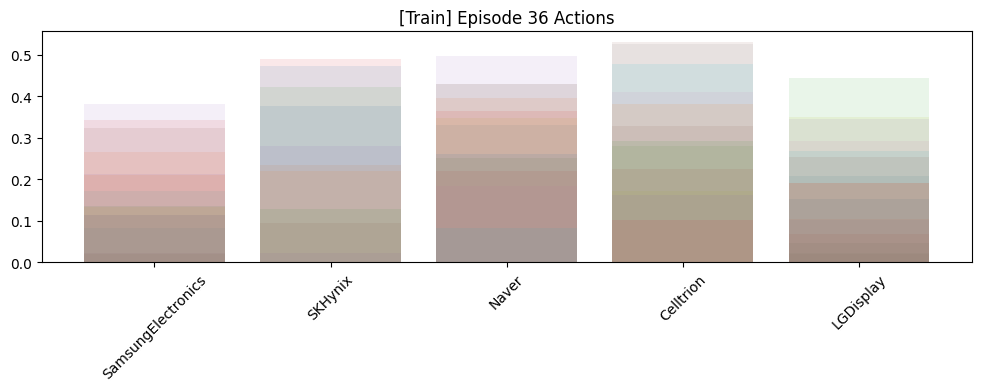

Episode 37/40 - Epsilon: 0.835


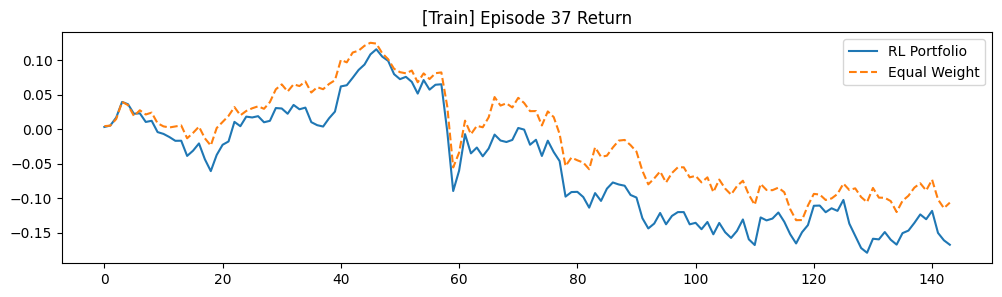

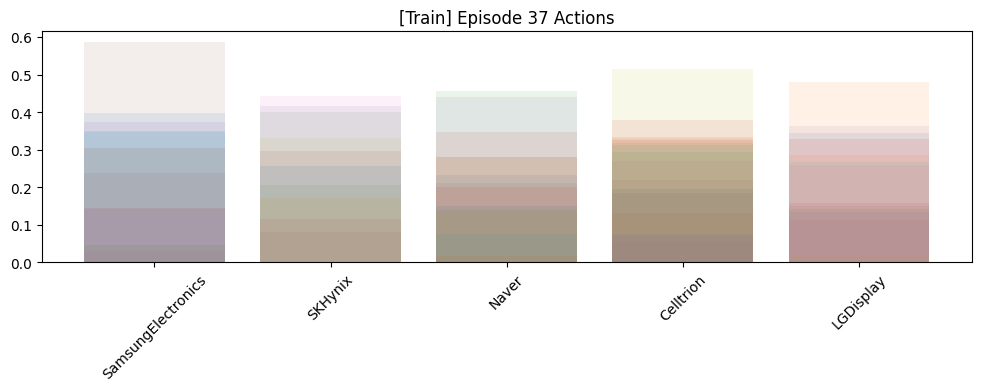

Episode 38/40 - Epsilon: 0.835


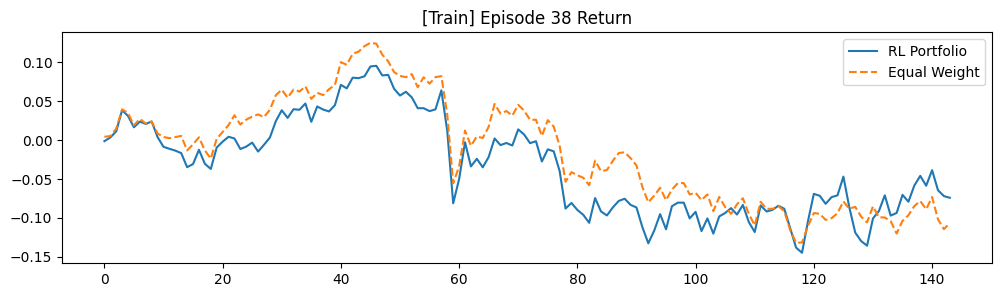

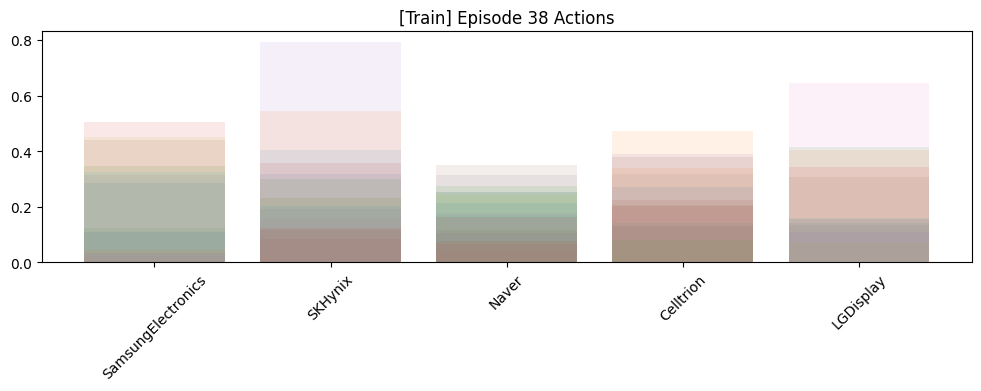

Episode 39/40 - Epsilon: 0.826


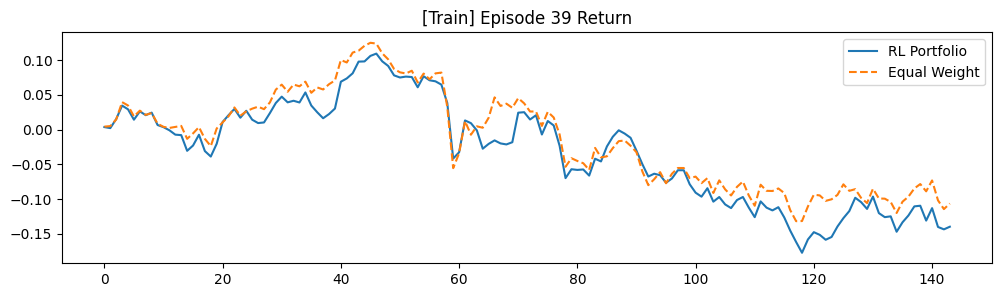

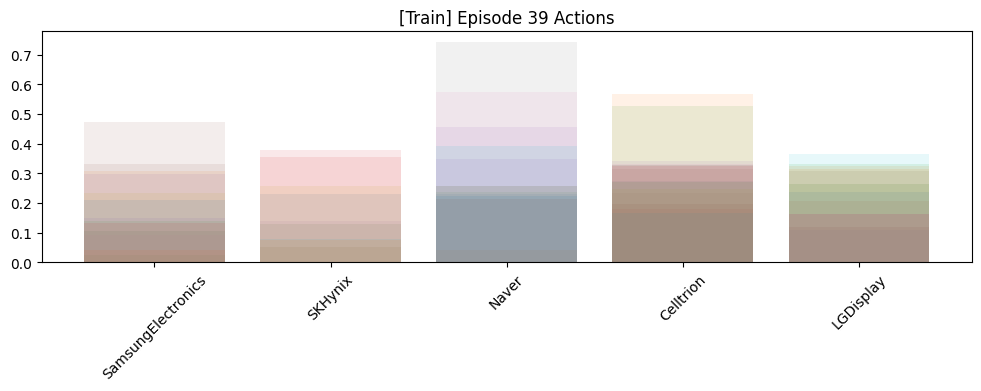

Episode 40/40 - Epsilon: 0.826


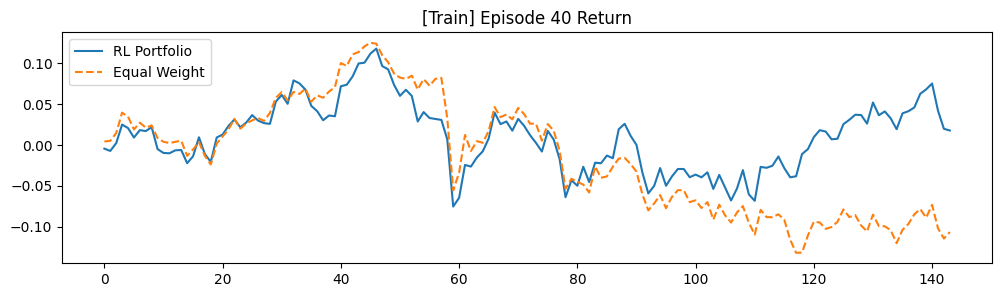

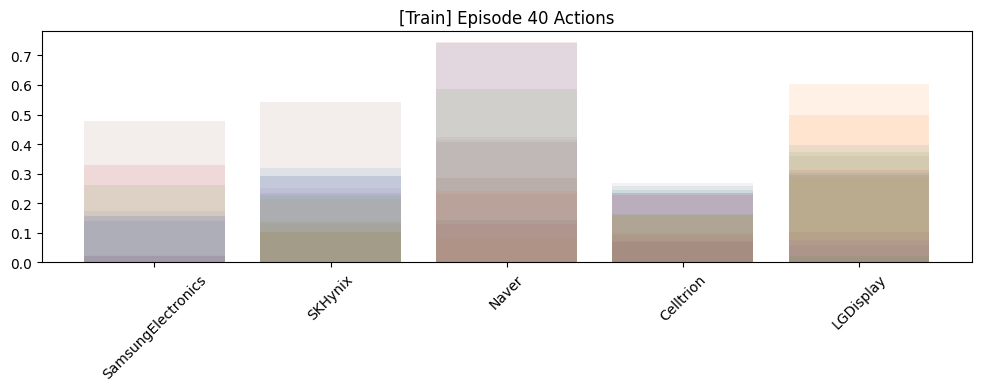

In [17]:
# ===============================================
# Part 4) 학습(Train) 루프
# ===============================================

# 1) Train 환경 & 에이전트 준비
env_train = StockEnvironment(mode='train')
agent = Agent(portfolio_size=5, allow_short=False)

# 하이퍼파라미터
window_size = 90
rebalance_period = 10
batch_size = 32
episode_count = 40

train_len = len(env_train.data)

# 2) 여러 에피소드(episode_count) 반복
for e in range(episode_count):
    print(f"Episode {e+1}/{episode_count} - Epsilon: {agent.epsilon:.3f}")

    # 초기 상태: 무작위 시점
    s = env_train.get_state(
        np.random.randint(window_size+1, train_len - window_size - 1),
        window_size
    )

    returns_rl, returns_eq, actions = [], [], []

    # 3) 리밸런싱 주기마다 매매
    for t in range(window_size, train_len, rebalance_period):
        date1 = t - rebalance_period
        if date1 < 0:
            continue

        s_ = env_train.get_state(t, window_size)

        # 에이전트가 행동 결정
        action = agent.act(s_)
        actions.append(action)

        # RL 포트폴리오 vs 균등 분산
        r1, reward = env_train.get_reward(action, date1, t)
        r2, reward_eq = env_train.get_reward(np.ones(5)/5, date1, t)

        # 누적
        returns_rl.extend(r1)
        returns_eq.extend(r2)

        # 종료 여부
        done = (t >= train_len - rebalance_period)

        # 리플레이 메모리에 저장
        agent.memory.append((s, s_, action, reward, done))

        # 일정 메모리 이상이면 학습
        if len(agent.memory) >= batch_size:
            agent.expReplay(batch_size)

        s = s_

    # 4) 에피소드 결과 그래프
    plt.figure(figsize=(12, 3))
    plt.plot(np.array(returns_rl).cumsum(), label='RL Portfolio')
    plt.plot(np.array(returns_eq).cumsum(), label='Equal Weight', linestyle='--')
    plt.legend()
    plt.title(f'[Train] Episode {e+1} Return')
    plt.show()

    plt.figure(figsize=(12, 3))
    for a in actions:
        plt.bar(np.arange(5), a, alpha=0.1)
    plt.xticks(np.arange(5), env_train.data.columns, rotation=45)
    plt.title(f'[Train] Episode {e+1} Actions')
    plt.show()


In [18]:
# ===============================================
# Part 5) 테스트(Test) 루프 & 최종 그래프
# ===============================================

# 학습 완료 후 평가
agent.is_eval = True
env_test = StockEnvironment(mode='test')
test_len = len(env_test.data)

test_window_size = 20 #window_size 조정

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

# 간단히 1회 시뮬레이션
for t in range(test_window_size, test_len, rebalance_period):
    date1 = t - rebalance_period
    if date1 < 0:
        continue

    s_test = env_test.get_state(t, test_window_size)
    action_test = agent.act(s_test)

    # RL과 균등 분산 비교
    weighted_returns, reward_test = env_test.get_reward(action_test, date1, t)
    weighted_returns_equal, reward_equal_test = env_test.get_reward(
        np.ones(agent.portfolio_size)/agent.portfolio_size,
        date1, t
    )

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size)/agent.portfolio_size)

    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action_test)

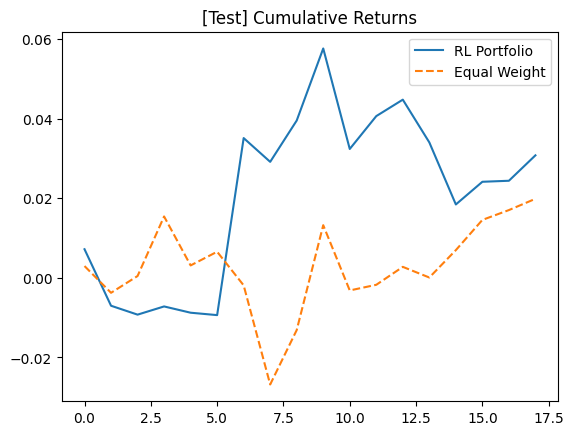

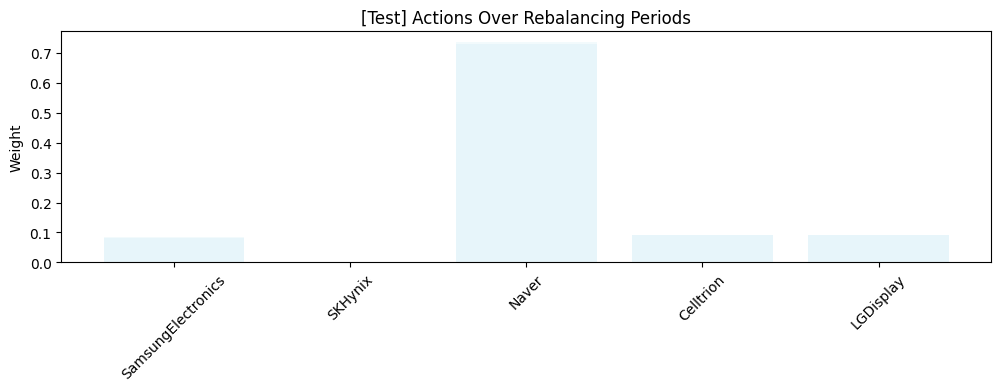

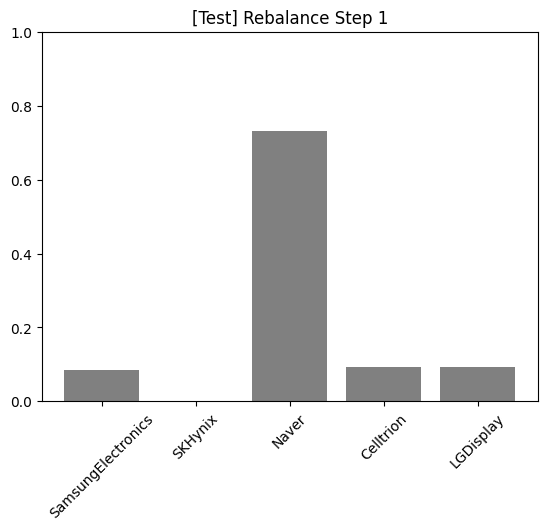

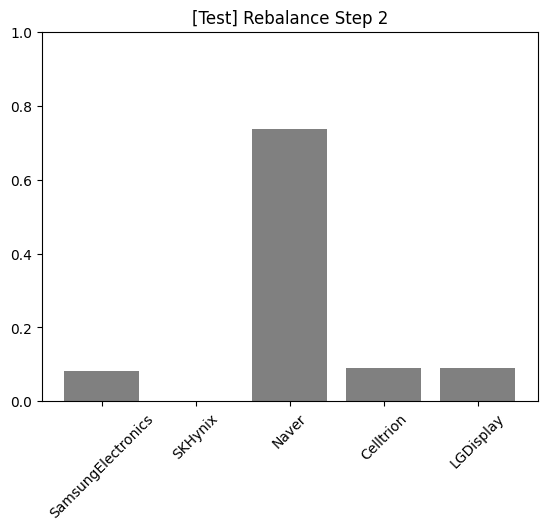

In [19]:
# (A) 누적수익률 그래프
flat_rl = np.array([val for sublist in result_rl for val in sublist])
flat_eq = np.array([val for sublist in result_equal for val in sublist])

plt.figure()
plt.plot(flat_rl.cumsum(), label='RL Portfolio')
plt.plot(flat_eq.cumsum(), label='Equal Weight', linestyle='--')
plt.legend()
plt.title('[Test] Cumulative Returns')
plt.show()

# (B) 액션(가중치) 시각화
plt.figure(figsize=(12, 3))
for a in actions_rl:
    plt.bar(np.arange(5), a, alpha=0.1, color='skyblue')
plt.xticks(np.arange(5), env_test.data.columns, rotation=45)
plt.ylabel("Weight")
plt.title('[Test] Actions Over Rebalancing Periods')
plt.show()


for i, a in enumerate(actions_rl):
    plt.figure()
    plt.bar(np.arange(5), a, color='gray')
    plt.xticks(np.arange(5), env_test.data.columns, rotation=45)
    plt.title(f'[Test] Rebalance Step {i+1}')
    plt.ylim(0, 1)
    plt.show()


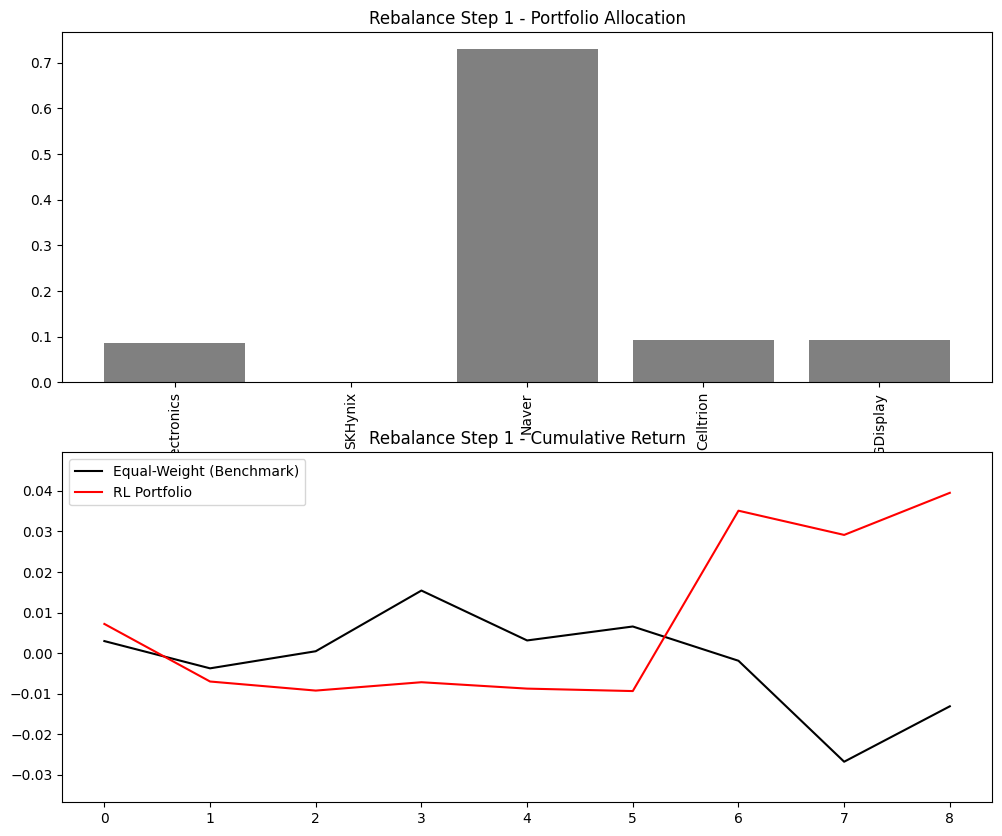

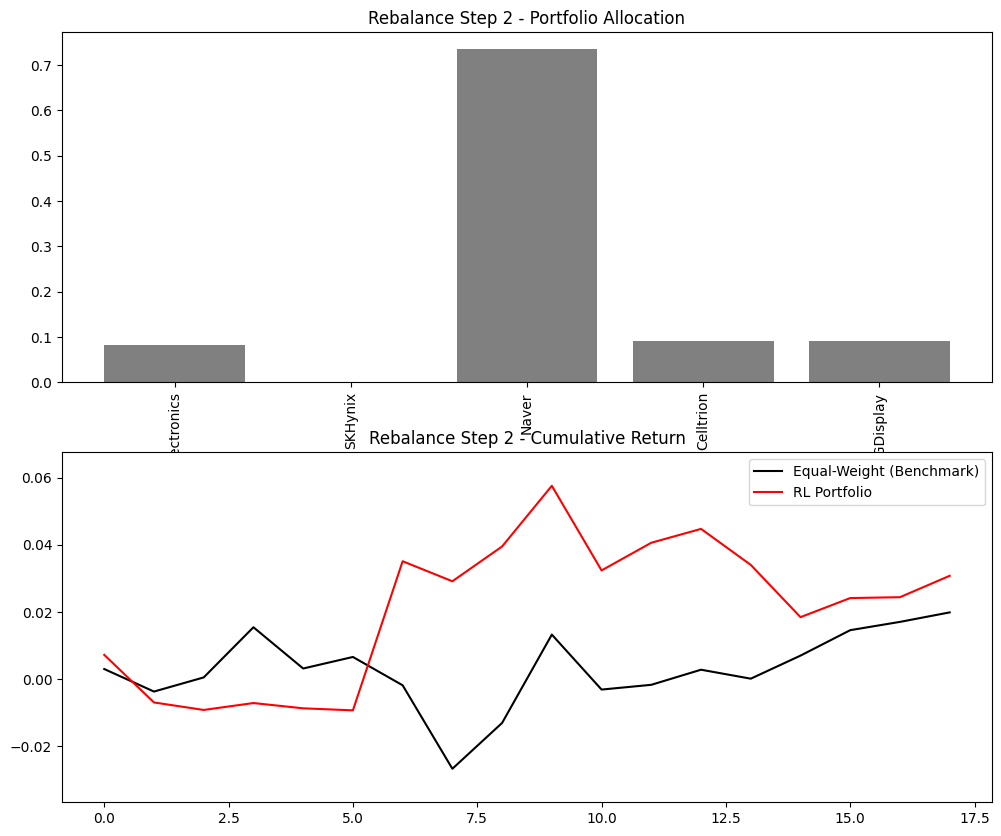

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# 색상맵 설정
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
N_ASSETS=5
# 총 시간 길이 계산
N = len([item for sublist in result_equal for item in sublist])

# 평탄화 수익률 (flattened)
flat_equal = np.array([item for sublist in result_equal for item in sublist])
flat_rl = np.array([item for sublist in result_rl for item in sublist])

for i in range(len(actions_rl)):
    # 현재까지의 누적 수익률 계산
    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()
    
    t = len(ts_benchmark)
    current_range = np.arange(t)

    plt.figure(figsize=(12, 10))

    # 1. 막대 그래프 (에이전트가 선택한 포트폴리오 비중)
    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color='grey')
    plt.xticks(np.arange(N_ASSETS), env_test.data.columns, rotation='vertical')
    plt.title(f"Rebalance Step {i+1} - Portfolio Allocation")

    # 2. 선 그래프 (누적 수익률 비교)
    y_min = min(ts_benchmark.min(), ts_target.min())
    y_max = max(ts_benchmark.max(), ts_target.max())
    margin = 0.01  # 1% 여유

    plt.subplot(2, 1, 2)
    plt.plot(current_range, ts_benchmark, color='black', label='Equal-Weight (Benchmark)')
    plt.plot(current_range, ts_target, color='red', label='RL Portfolio')
    plt.ylim([y_min - margin, y_max + margin])
    plt.legend()
    plt.title(f"Rebalance Step {i+1} - Cumulative Return")


In [21]:
# 초기 포트폴리오 상태
N_ASSETS = len(env_test.data.columns)  #  5개 종목
shares_held = np.zeros(N_ASSETS)       # 각 종목별 보유 주식 수
cash = 5e7                             # 5천만원

for i in range(len(actions_rl)):
    # --------------------------------
    # 1) 현재 시점 가격 불러오기
    # --------------------------------
    price_idx = (i + 1)*rebalance_period - 1
    if price_idx >= len(env_test.data):
        price_idx = len(env_test.data) - 1
    
    current_prices = env_test.data.iloc[price_idx].values  # shape: (N_ASSETS,)
    
    # --------------------------------
    # 2) 현재 포트폴리오 평가액 계산
    # --------------------------------
    # 주식 평가액 + 남은 현금
    portfolio_value = np.sum(shares_held * current_prices) + cash
    
    # --------------------------------
    # 3) 이번 리밸런싱 목표 비중
    # --------------------------------
    weights = actions_rl[i]  # 에이전트가 결정한 비중 (합이 1 가정)
    
    # 목표 가치
    desired_value = portfolio_value * weights  # shape: (N_ASSETS,)
    
    # --------------------------------
    # 4) 자산별 현재 가치 vs 목표 가치 비교 → 매도/매수
    # --------------------------------
    print(f"\n📌 Rebalance Step {i+1}")
    print(f"현재 포트폴리 평가액: {portfolio_value:,.0f} 원, 현금잔고: {cash:,.0f} 원")

    for idx_asset, asset_name in enumerate(env_test.data.columns):
        current_val = shares_held[idx_asset] * current_prices[idx_asset]  # 현재 종목 가치
        target_val = desired_value[idx_asset]                             # 목표 가치
        diff = target_val - current_val
        
        if diff > 0:
            # (매수) 목표 가치가 현재 가치보다 크면 부족분만큼 매수
            buy_amount = diff
            # 실제 매수 주식 수
            buy_shares = buy_amount / current_prices[idx_asset]
            # 보유 주식 +, 현금 -
            shares_held[idx_asset] += buy_shares
            cash -= buy_amount
            
            print(f"  - {asset_name} 매수: {buy_shares:.4f} 주, "
                  f"비중 {weights[idx_asset]*100:.2f}%, "
                  f"금액 {buy_amount:,.0f} 원")
            
        else:
            # (매도) 목표 가치보다 현재 가치가 크면 초과분 매도
            sell_amount = abs(diff)
            sell_shares = sell_amount / current_prices[idx_asset]
            shares_held[idx_asset] -= sell_shares
            cash += sell_amount
            
            print(f"  - {asset_name} 매도: {sell_shares:.4f} 주, "
                  f"비중 {weights[idx_asset]*100:.2f}%, "
                  f"금액 {sell_amount:,.0f} 원")

    print(f"리밸런싱 후 남은 현금: {cash:,.0f} 원")




📌 Rebalance Step 1
현재 포트폴리 평가액: 50,000,000 원, 현금잔고: 50,000,000 원
  - SamsungElectronics 매수: 79.2521 주, 비중 8.51%, 금액 4,255,840 원
  - SKHynix 매도: 0.0000 주, 비중 0.00%, 금액 0 원
  - Naver 매수: 177.7438 주, 비중 73.05%, 금액 36,524,937 원
  - Celltrion 매수: 25.5097 주, 비중 9.22%, 금액 4,609,611 원
  - LGDisplay 매수: 509.3493 주, 비중 9.22%, 금액 4,609,611 원
리밸런싱 후 남은 현금: 0 원

📌 Rebalance Step 2
현재 포트폴리 평가액: 51,969,267 원, 현금잔고: 0 원
  - SamsungElectronics 매수: 2.0585 주, 비중 8.25%, 금액 108,482 원
  - SKHynix 매도: 0.0000 주, 비중 0.00%, 금액 0 원
  - Naver 매도: 1.9108 주, 비중 73.57%, 금액 415,473 원
  - Celltrion 매수: 1.1312 주, 비중 9.09%, 금액 200,680 원
  - LGDisplay 매수: 11.7212 주, 비중 9.09%, 금액 106,311 원
리밸런싱 후 남은 현금: -0 원


In [22]:
#포트폴리오 성과를 종합적으로 평가하는 함수
#평균수익률,변동성,샤프비율,알파,베타
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [23]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

NameError: name 'result_equal_vis' is not defined